In [1]:
import os
from datetime import datetime, timedelta
from enum import Enum
import mlflow
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from test_case_utils import WeatherParams, TestCase, TargetCases, MlflowConfig

In [34]:
###
# Utils for plotting
###
class TargetManilaErea:
    MAX_LONGITUDE = 121.150
    MIN_LONGITUDE = 120.90

    MAX_LATITUDE = 14.760
    MIN_LATITUDE = 14.350


def create_img_from_griddata(ax, grid_data, color_levels, color_map, contour: bool = False):
    grid_lon = np.round(np.linspace(TargetManilaErea.MIN_LONGITUDE, TargetManilaErea.MAX_LONGITUDE), decimals=3)
    grid_lat = np.round(np.linspace(TargetManilaErea.MIN_LATITUDE, TargetManilaErea.MAX_LATITUDE), decimals=3)

    # fig = plt.figure(figsize=(7, 8), dpi=80)
    # ax = fig.add_subplot(1, 1, 1)

    xi, yi = np.meshgrid(grid_lon, grid_lat)
    if contour:
        # Add contour lines
        c = ax.contour(xi, np.flip(yi), grid_data, colors=['black'], linestyles='dashed')

    # Add heat map
    cs = ax.contourf(
        xi, np.flip(yi), grid_data, color_levels, cmap=color_map, norm=mcolors.BoundaryNorm(color_levels, color_map.N)
    )
    return cs


def timeseries_geo_plot(
    subfig,
    suptitle: str,
    target_param: str, 
    data: list,
    xlabels = None
):
    subfig.suptitle(suptitle, fontsize=20)
    axs = subfig.subplots(nrows=1, ncols=len(data), subplot_kw=dict(projection=ccrs.PlateCarree()))
    for col, ax in enumerate(axs):
        # Add time step
        if xlabels:
            ax.set_xlabel(xlabels[col], fontsize=15, labelpad=20)
            ax.set_xticks([]) # So that ax.set_xlabel works
        ax.set_extent(
            [
                TargetManilaErea.MIN_LONGITUDE,
                TargetManilaErea.MAX_LONGITUDE,
                TargetManilaErea.MIN_LATITUDE,
                TargetManilaErea.MAX_LATITUDE,
            ],
            crs=ccrs.PlateCarree(),
        )
        gl = ax.gridlines(draw_labels=True, alpha=0)
        gl.right_labels = False
        gl.top_labels = False

        cs = create_img_from_griddata(
            ax,
            data[col],
            WeatherParams.get_clevels(target_param),
            WeatherParams.get_cmap(target_param),
            contour=False if target_param == WeatherParams.rainfall else True
        )

        ax.add_feature(cfeature.COASTLINE)
    cbar = plt.colorbar(cs, ax=axs)
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label(WeatherParams.unit(target_param), fontsize=20)

def xlabels_from_times(times: list[str]):
    times = [s.replace('-', ':') for s in times]
    times = [t.replace(':0', ':00') if t.endswith(':0') else t for t in times]
    return [f'{t} UTC' for t in times]


###
# Data Cleaning
###
def get_zero_diff_count(series: pd.Series):
    return (series == 0).sum()

def check_abnormal_datapoint(data_df):
    y_labels = {
        "hour-rain": "Hourly rainfall (mm/h)",
        "AT1": "Temperature (℃)",
        "RH1": "Relative Humidity (%)",
        "WS1": "Wind Speed (m/s)",
        "V-Wind": "North-south wind speed(m/s)",
        "U-Wind": "East-west wind speed (m/s)",
        "PRS": "Station Pressure (hPa)",
    }
    for col in ['AT1', 'RH1']:
        if col in list(y_labels.keys()):
            # Check outliers
            ## 1. same value is continuing (except for hour-rain)
            grouped_by_station = data_df.groupby(by=["Station_Name"])
            if col != "hour-rain":
                check_same_value_df = data_df.sort_values(by=["Station_Name", "time_step"])
                check_same_value_df["diff"] = check_same_value_df.groupby(by=["Station_Name"])[col].diff()
                zero_diff_count_series = check_same_value_df.groupby(by=["Station_Name"])["diff"].agg(get_zero_diff_count)
                for observation_name in zero_diff_count_series.index:
                    zero_diff_count = zero_diff_count_series[observation_name]
                    print(zero_diff_count)
                    if zero_diff_count > 50:
                        print(f"{col} data of {observation_name} has {zero_diff_count} zero different values.")

###
# Interpolate with exclude obpoints
# Poteka has abnormal observation values such as same value everytime.
###
from scipy.interpolate import RBFInterpolator
import sys
sys.path.append('../')
from common.config import PPOTEKACols, MinMaxScalingValue
from evaluate.src.interpolator.humidity_interpolator import HumidityInterplator
from evaluate.src.interpolator.temperature_interpolator import TemperatureInterpolator

def interpolate(df: pd.DataFrame, param_name: str, exclude_obpoints: list = ['Vlz-Bagbaguin_00174731', 'MM-EFCOS_00173456', 'CentPark_00181288']):
    WeatherParams.valid(param_name)
    df = df.loc[~df['Station_Name'].isin(exclude_obpoints)]
    obpoint_lons, obpoint_lats = df['LON'].tolist(), df['LAT'].tolist()
    target_col = PPOTEKACols.get_col_from_weather_param(param_name)

    min_val, max_val = MinMaxScalingValue.get_minmax_values_by_ppoteka_cols(target_col)
    data = (df[target_col].to_numpy() - min_val) / (max_val - min_val)
    rbfi = RBFInterpolator(
        y=np.column_stack([obpoint_lons, obpoint_lats]), d=data, kernel="linear", epsilon=10
    )
    grid_coordinate = np.mgrid[120.90:121.150:50j, 14.350:14.760:50j]

    y_pred = rbfi(grid_coordinate.reshape(2, -1).T)
    grid_data = np.reshape(y_pred, (50, 50)).T
    grid_data = np.flipud(grid_data)

    grid_data = np.where(grid_data > 0, grid_data, 0)
    grid_data = np.where(grid_data > 1, 1, grid_data)

    return grid_data.astype(np.float32) * (max_val - min_val) + min_val

In [41]:
###
# Time series change visualize of inputs
# Rainfall, Temperature and Humidity.
###
def visualize_timeseries_change(test_case_name, target_params = None, target_type: str = 'input', save_fig_path = None):
    """Visualize input data timeseries change"""
    if target_type not in ['input', 'label']:
        raise ValueError(f'target_type must be in [input, label] instaed of {target_type}.')

    if target_params == None:
        target_params = WeatherParams._member_names_

    if isinstance(target_params, str):
        target_params = [target_params]

    test_case = TestCase(test_case_name)
    input_seq_length = test_case.input_seq_length
    data_paths = test_case.data_pathes
    fig = plt.figure(constrained_layout=True, figsize=(21, 14))
    fig.suptitle('{} Case'.format(test_case.date.replace('-', '/')), fontsize=20)
    subfigs = fig.subfigures(nrows=len(target_params), ncols=1)
    for row, subfig in enumerate(subfigs):
        target_param = target_params[row]
        if target_param == WeatherParams.rainfall:
            data = [
                pd.read_csv(data_paths[target_param][target_type][col], index_col=0).to_numpy() for col in range(input_seq_length)
            ]
        else:
            data = [
                interpolate(pd.read_csv(data_paths['one_day_data'][target_type][idx]).rename(columns={'Unnamed: 0': 'Station_Name'}), param_name=target_param)
                for idx in range(input_seq_length)
            ]
        if target_type == 'input':
            xlabels = xlabels_from_times(test_case.input_times)
        else:
            xlabels = xlabels_from_times(test_case.pred_times)

        timeseries_geo_plot(subfig, target_param, target_param, data, xlabels)
    if save_fig_path:
        plt.savefig(save_fig_path, bbox_inches='tight')
    plt.show()
    plt.close()

###
# Visuzlise timeseries change of prediction and observation
# Observation, SA-ConvLSTM, ConvLSTM
def visualize_pred_vs_label(test_case_name, save_fig_path = None):
    pred_seq_length = 6

    test_case = TestCase(test_case_name)
    fig = plt.figure(constrained_layout=True, figsize=(21, 14))
    fig.suptitle('{} Case'.format(test_case.date.replace('-', '/')), fontsize=20)
    subfigs = fig.subfigures(nrows=3, ncols=1) # observation, rain only, rain_temp_humid
    for row, subfig in enumerate(subfigs):
        if row == 0:
            suptitle = 'Observation'
            data_paths = test_case.data_pathes[WeatherParams.rainfall]['label']
        elif row == 1:
            suptitle = 'Prediction of the model trained with rainfall, temperature and humidity.'
            data_paths = TestCase(test_case_name, run_id=MlflowConfig.eval_run_ids['rain_temp_humid']).data_pathes[WeatherParams.rainfall]['predict']
        else:
            suptitle = 'Prediction of the model trained with only rainfall'
            data_paths = TestCase(test_case_name, run_id=MlflowConfig.eval_run_ids['rain_only']).data_pathes[WeatherParams.rainfall]['predict']
        
        if row == 0:
            data = [pd.read_csv(data_paths[col], index_col=0).to_numpy() for col in range(pred_seq_length)]
        else:
            data = [pd.read_parquet(data_paths[col]).to_numpy() for col in range(pred_seq_length)]

        xlabels = xlabels_from_times(test_case.pred_times)
        timeseries_geo_plot(subfig, suptitle, WeatherParams.rainfall, data, xlabels)

    if save_fig_path:
        plt.savefig(save_fig_path)

    plt.show()
    plt.close()

In [39]:
###
# Visualize interpolation without abnormal observation point data
###
def visualize_interpolate_bf_af(test_case_name: str, run_id: str, target_param: str):
    WeatherParams.valid(target_param)

    test_case = TestCase(test_case_name, run_id=run_id)
    input_seq_length = test_case.input_seq_length
    data_paths = test_case.data_pathes
    # fig, axes = plt.subplots(len(target_params), input_seq_length, figsize=(30, 20))
    fig = plt.figure(constrained_layout=True, figsize=(25, 12))
    fig.suptitle('{} Case [{}]'.format(test_case.date.replace('-', '/'), target_param), fontsize=20)
    subfigs = fig.subfigures(nrows=2, ncols=1)
    for row, subfig in enumerate(subfigs):
        if row == 0:
            suptitle = 'before'
        else:
            suptitle = 'after'
        
        if row == 0:
            data = [pd.read_csv(data_paths[target_param]['input'][idx], index_col=0).to_numpy() for idx in range(input_seq_length)]
            xlabels = None
        else:
            data = [
                interpolate(pd.read_parquet(data_paths['one_day_data']['input'][idx]).rename(columns={'Unnamed: 0': 'Station_Name'}), param_name=target_param)
                for idx in range(input_seq_length)
            ]
            xlabels = xlabels_from_times(test_case.input_times)
        timeseries_geo_plot(subfig, suptitle, target_param, data, xlabels)

    plt.show()
    plt.close()

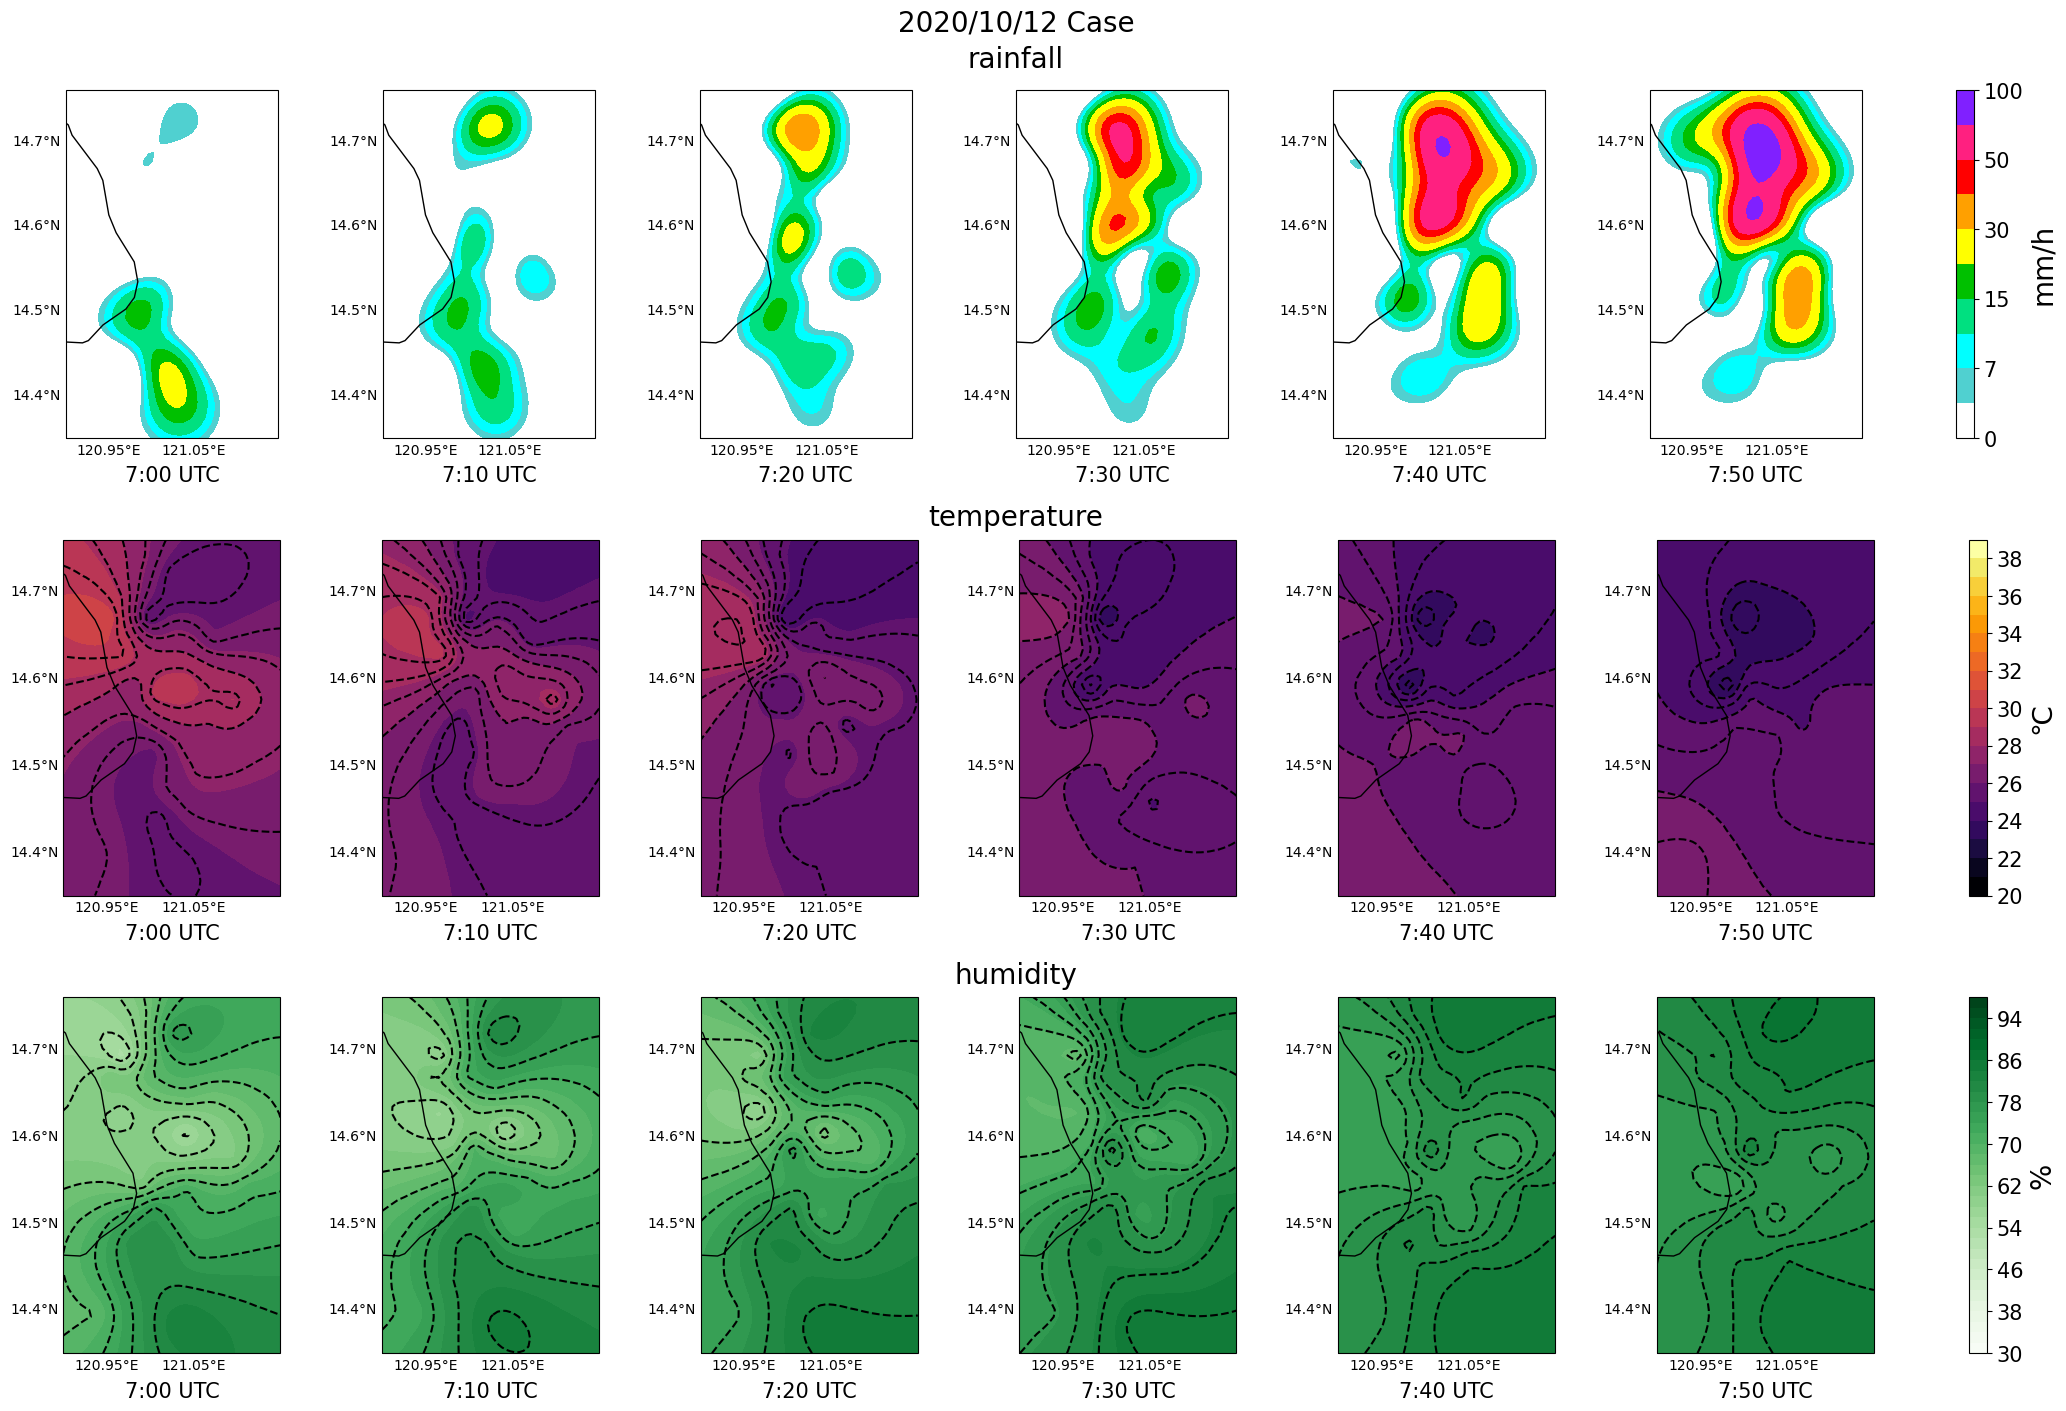

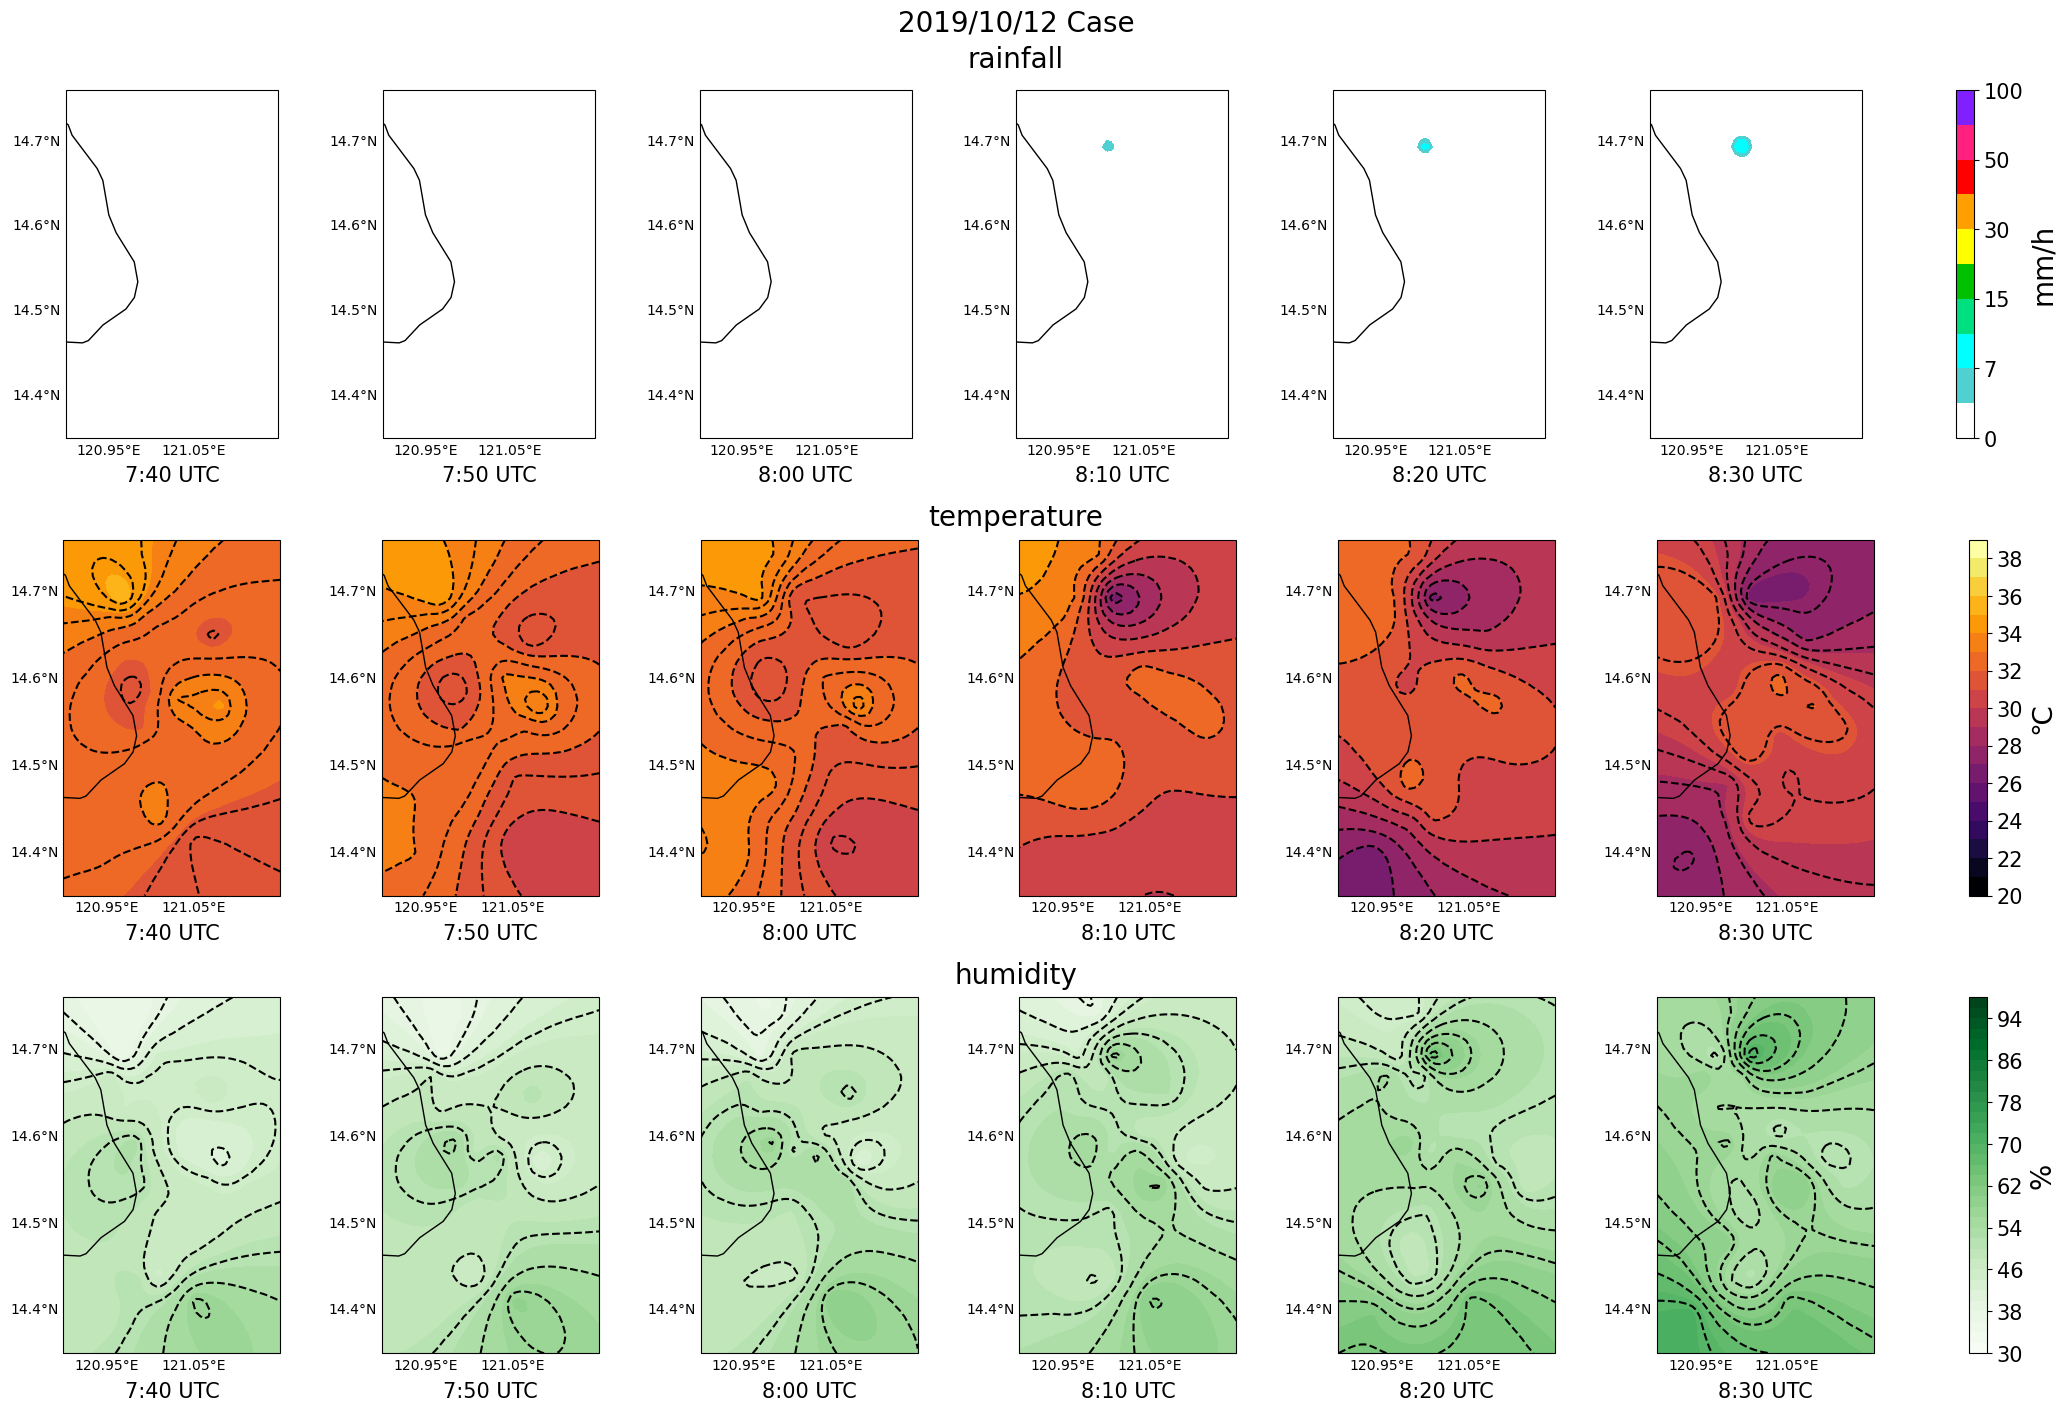

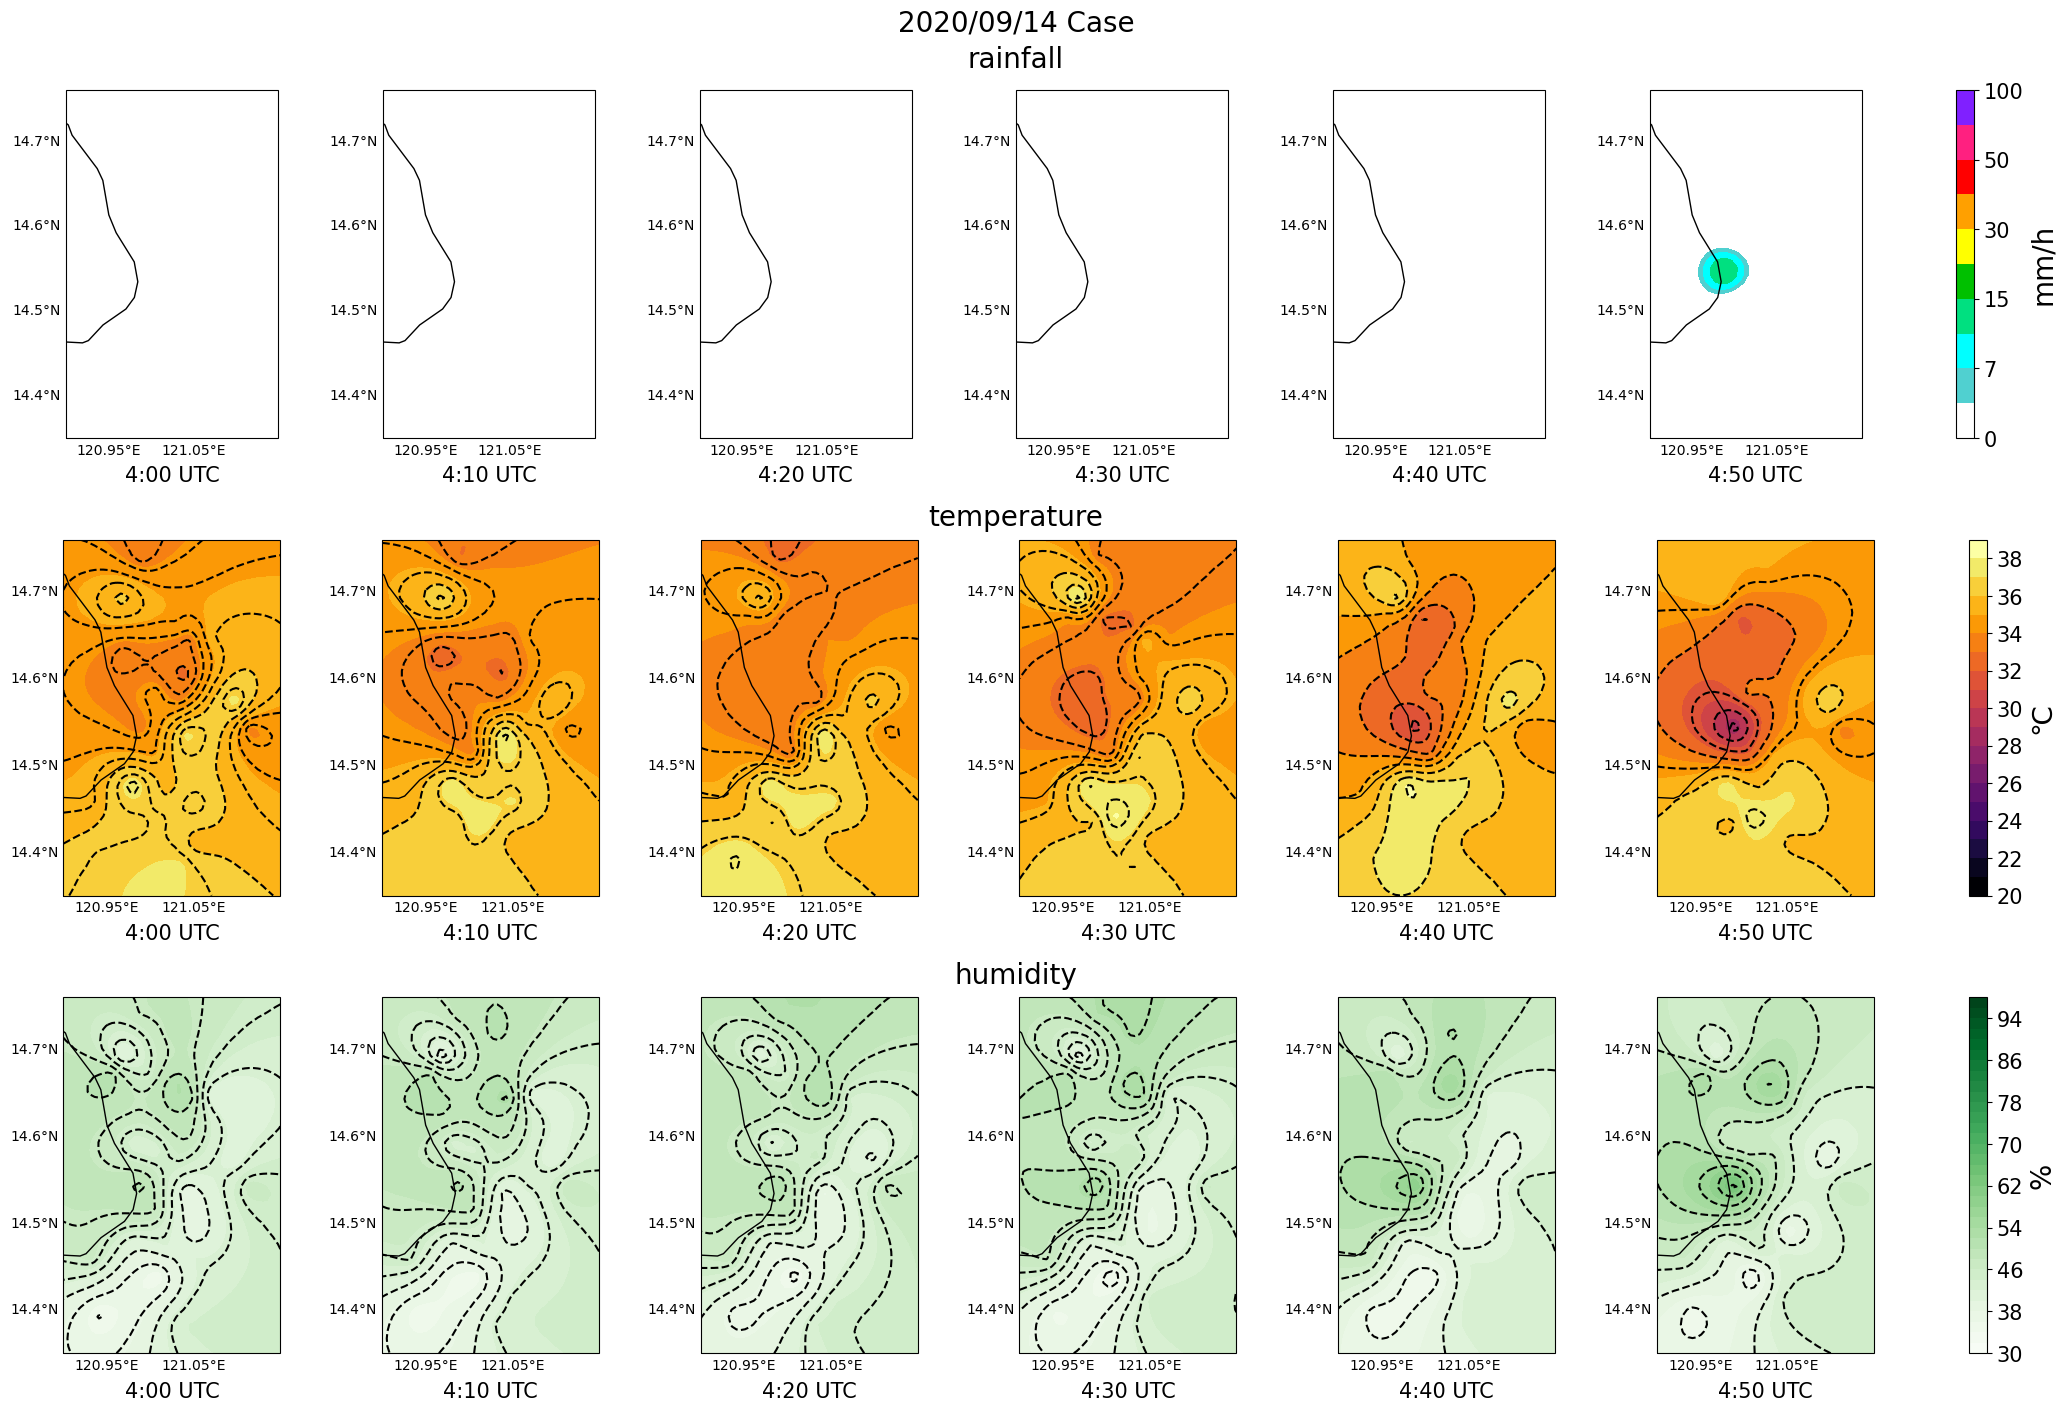

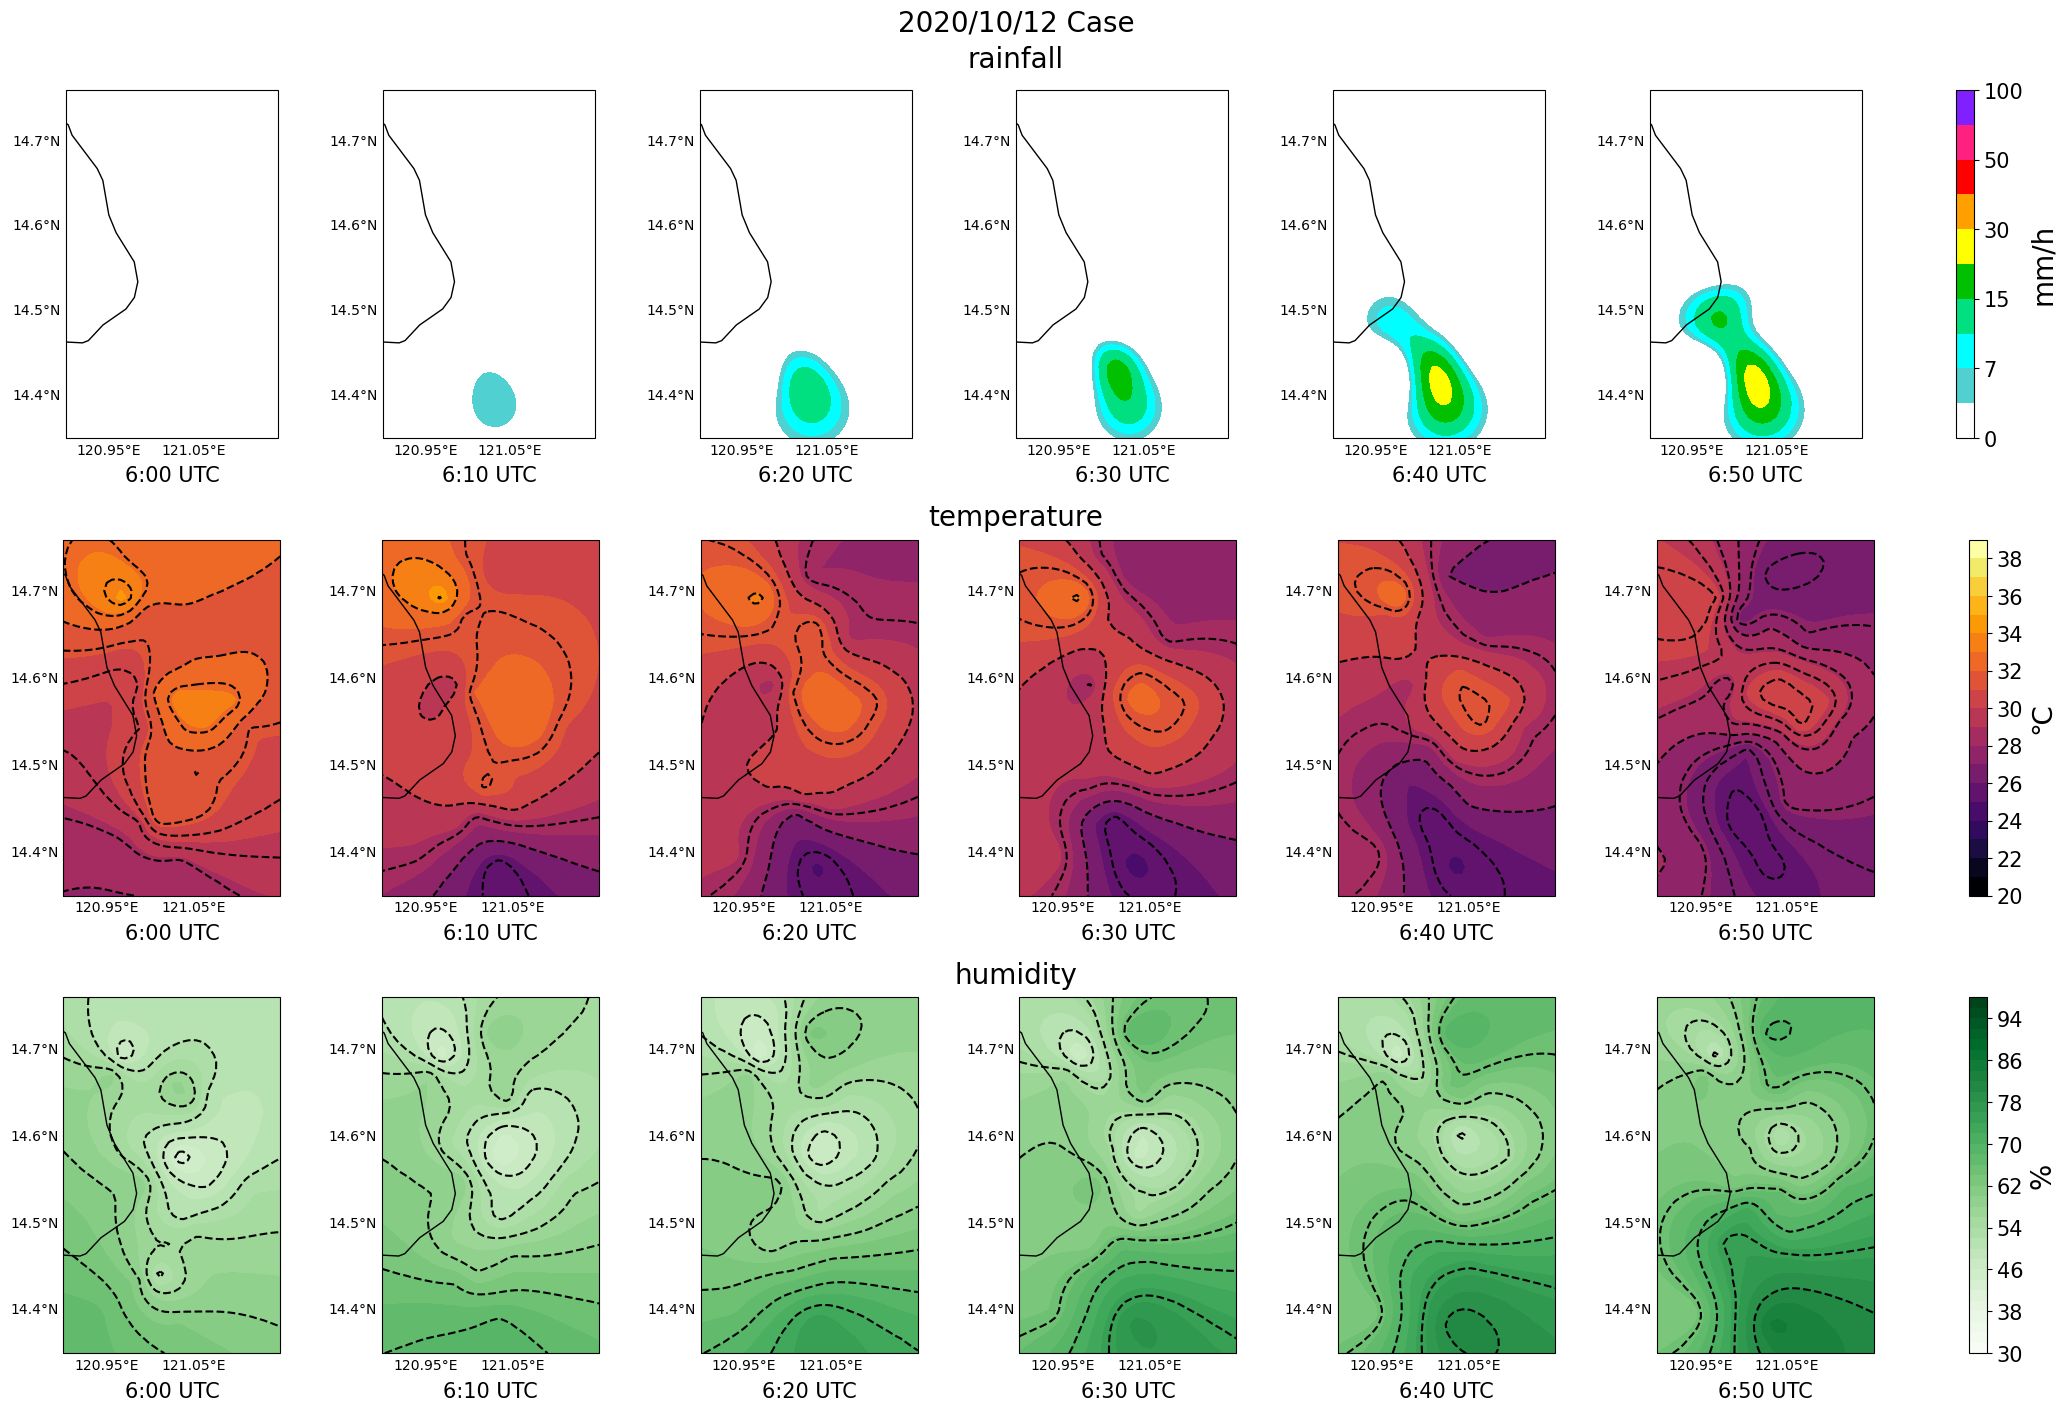

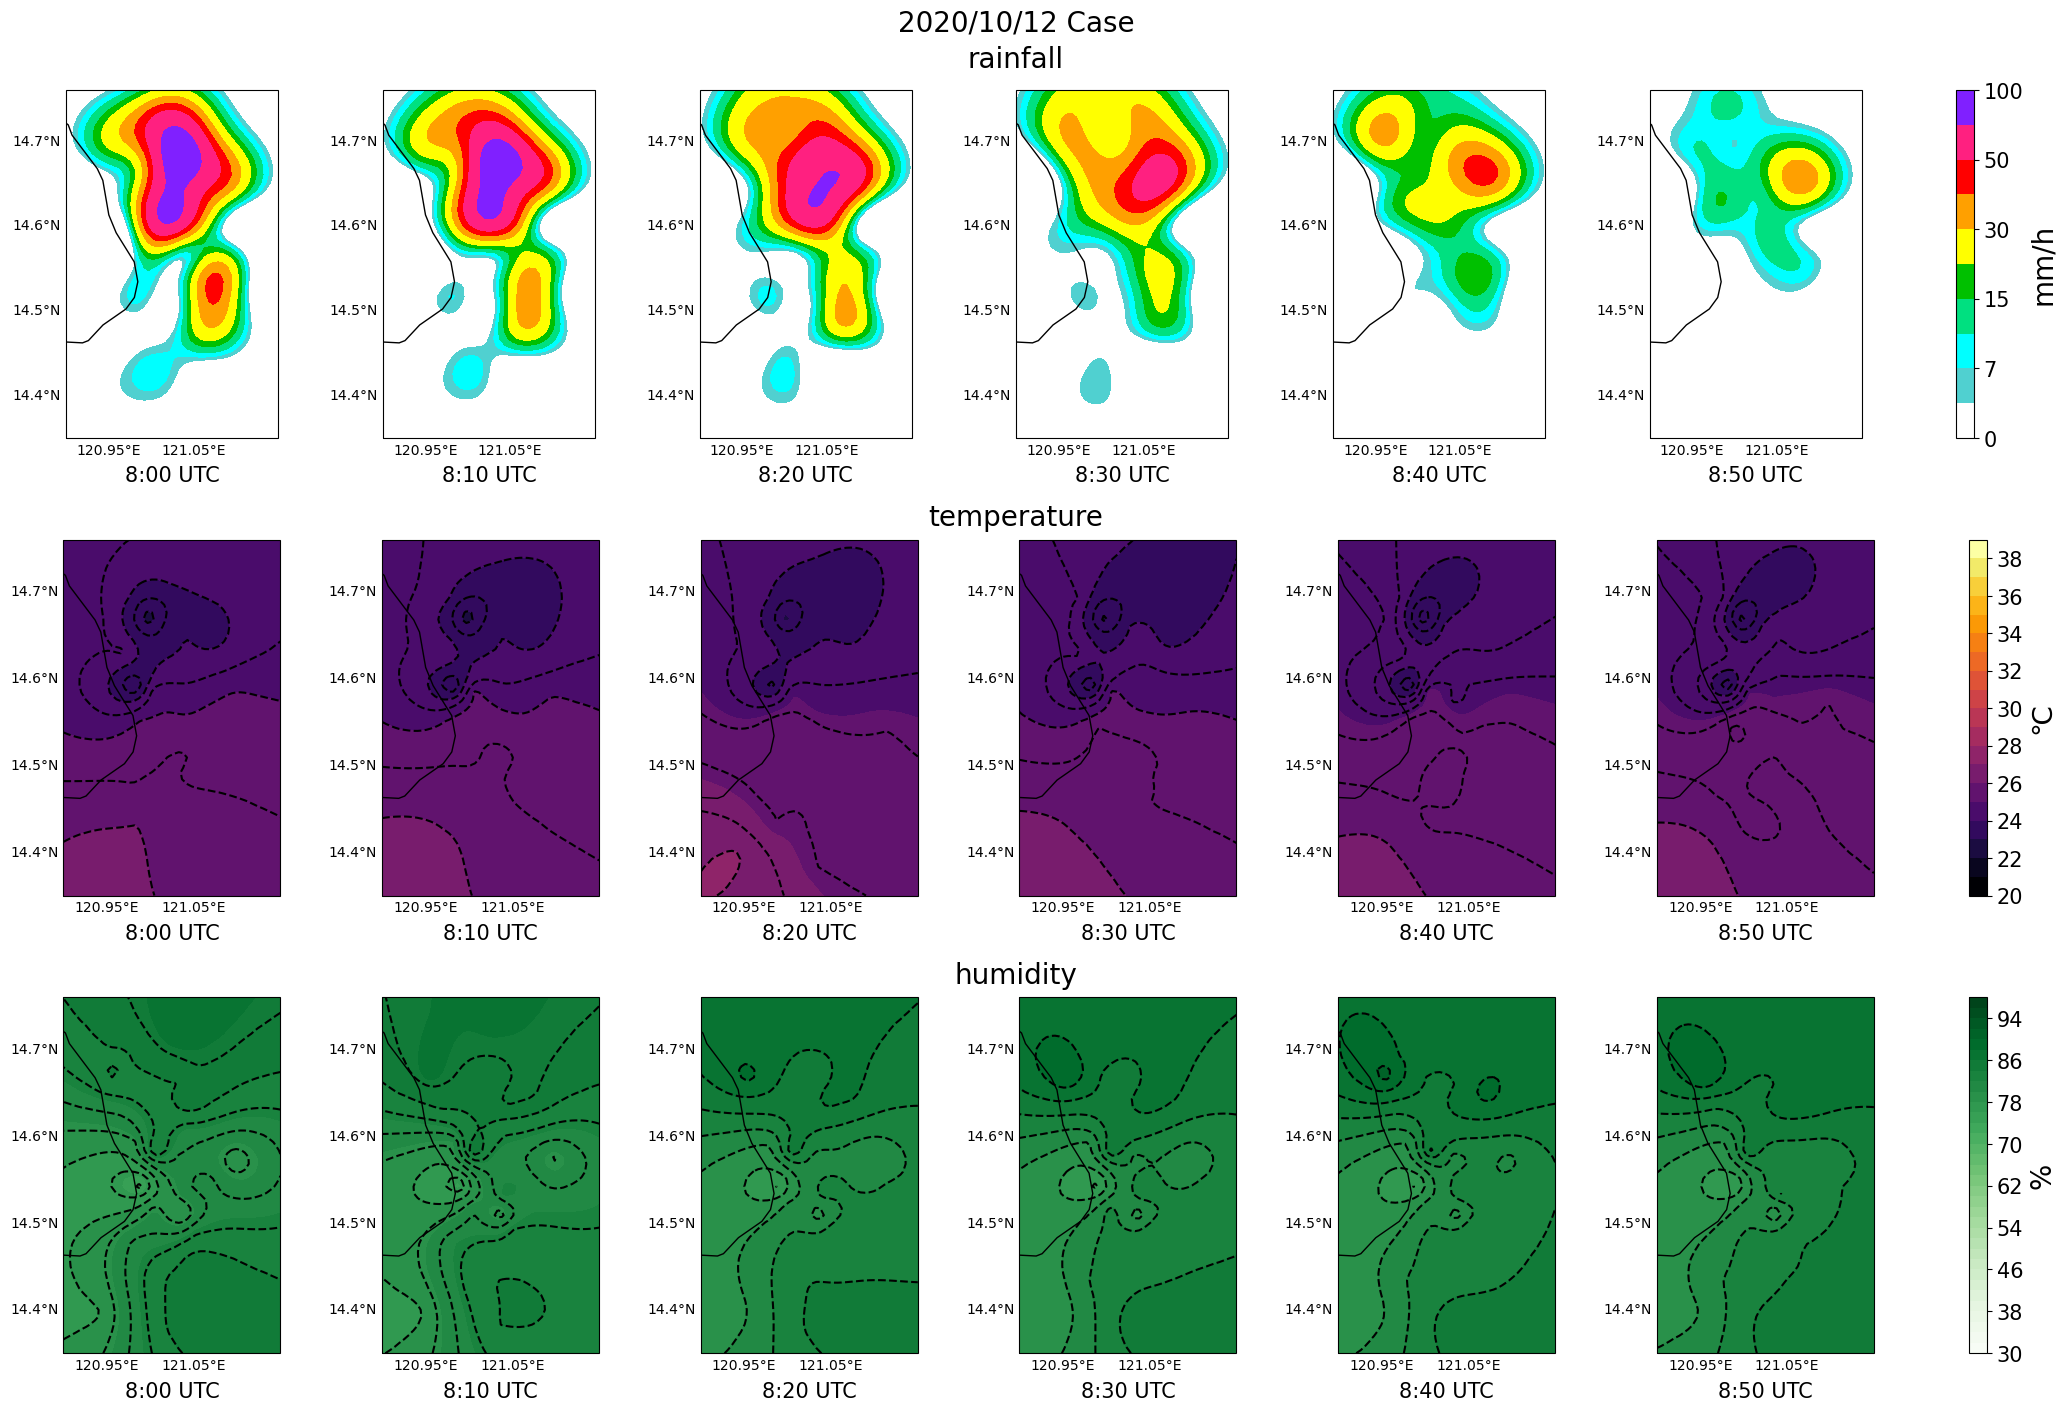

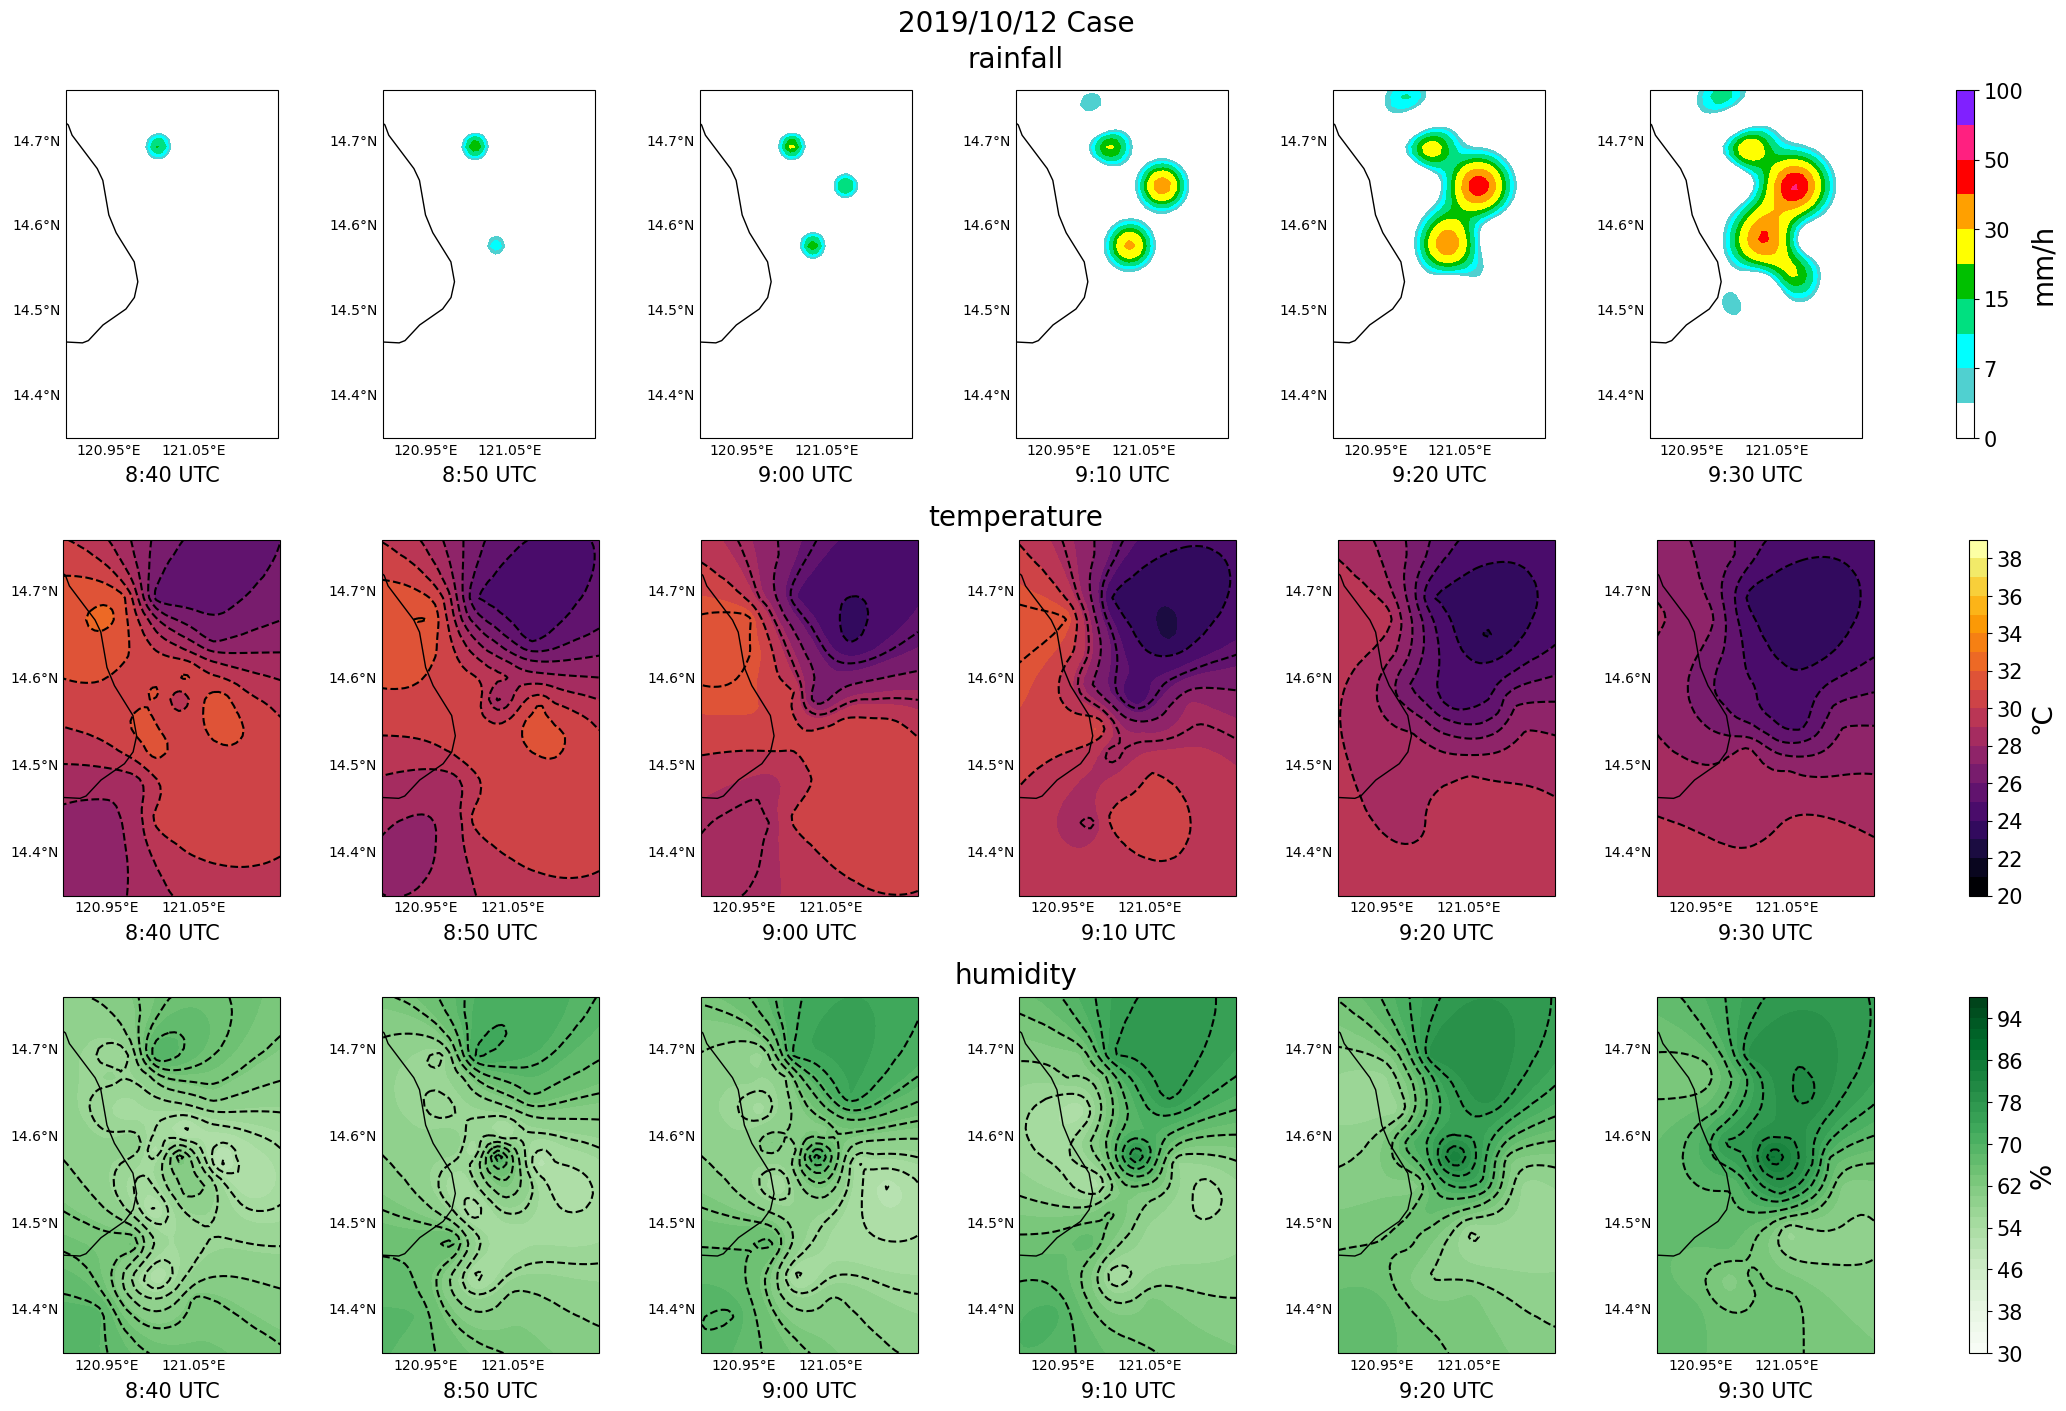

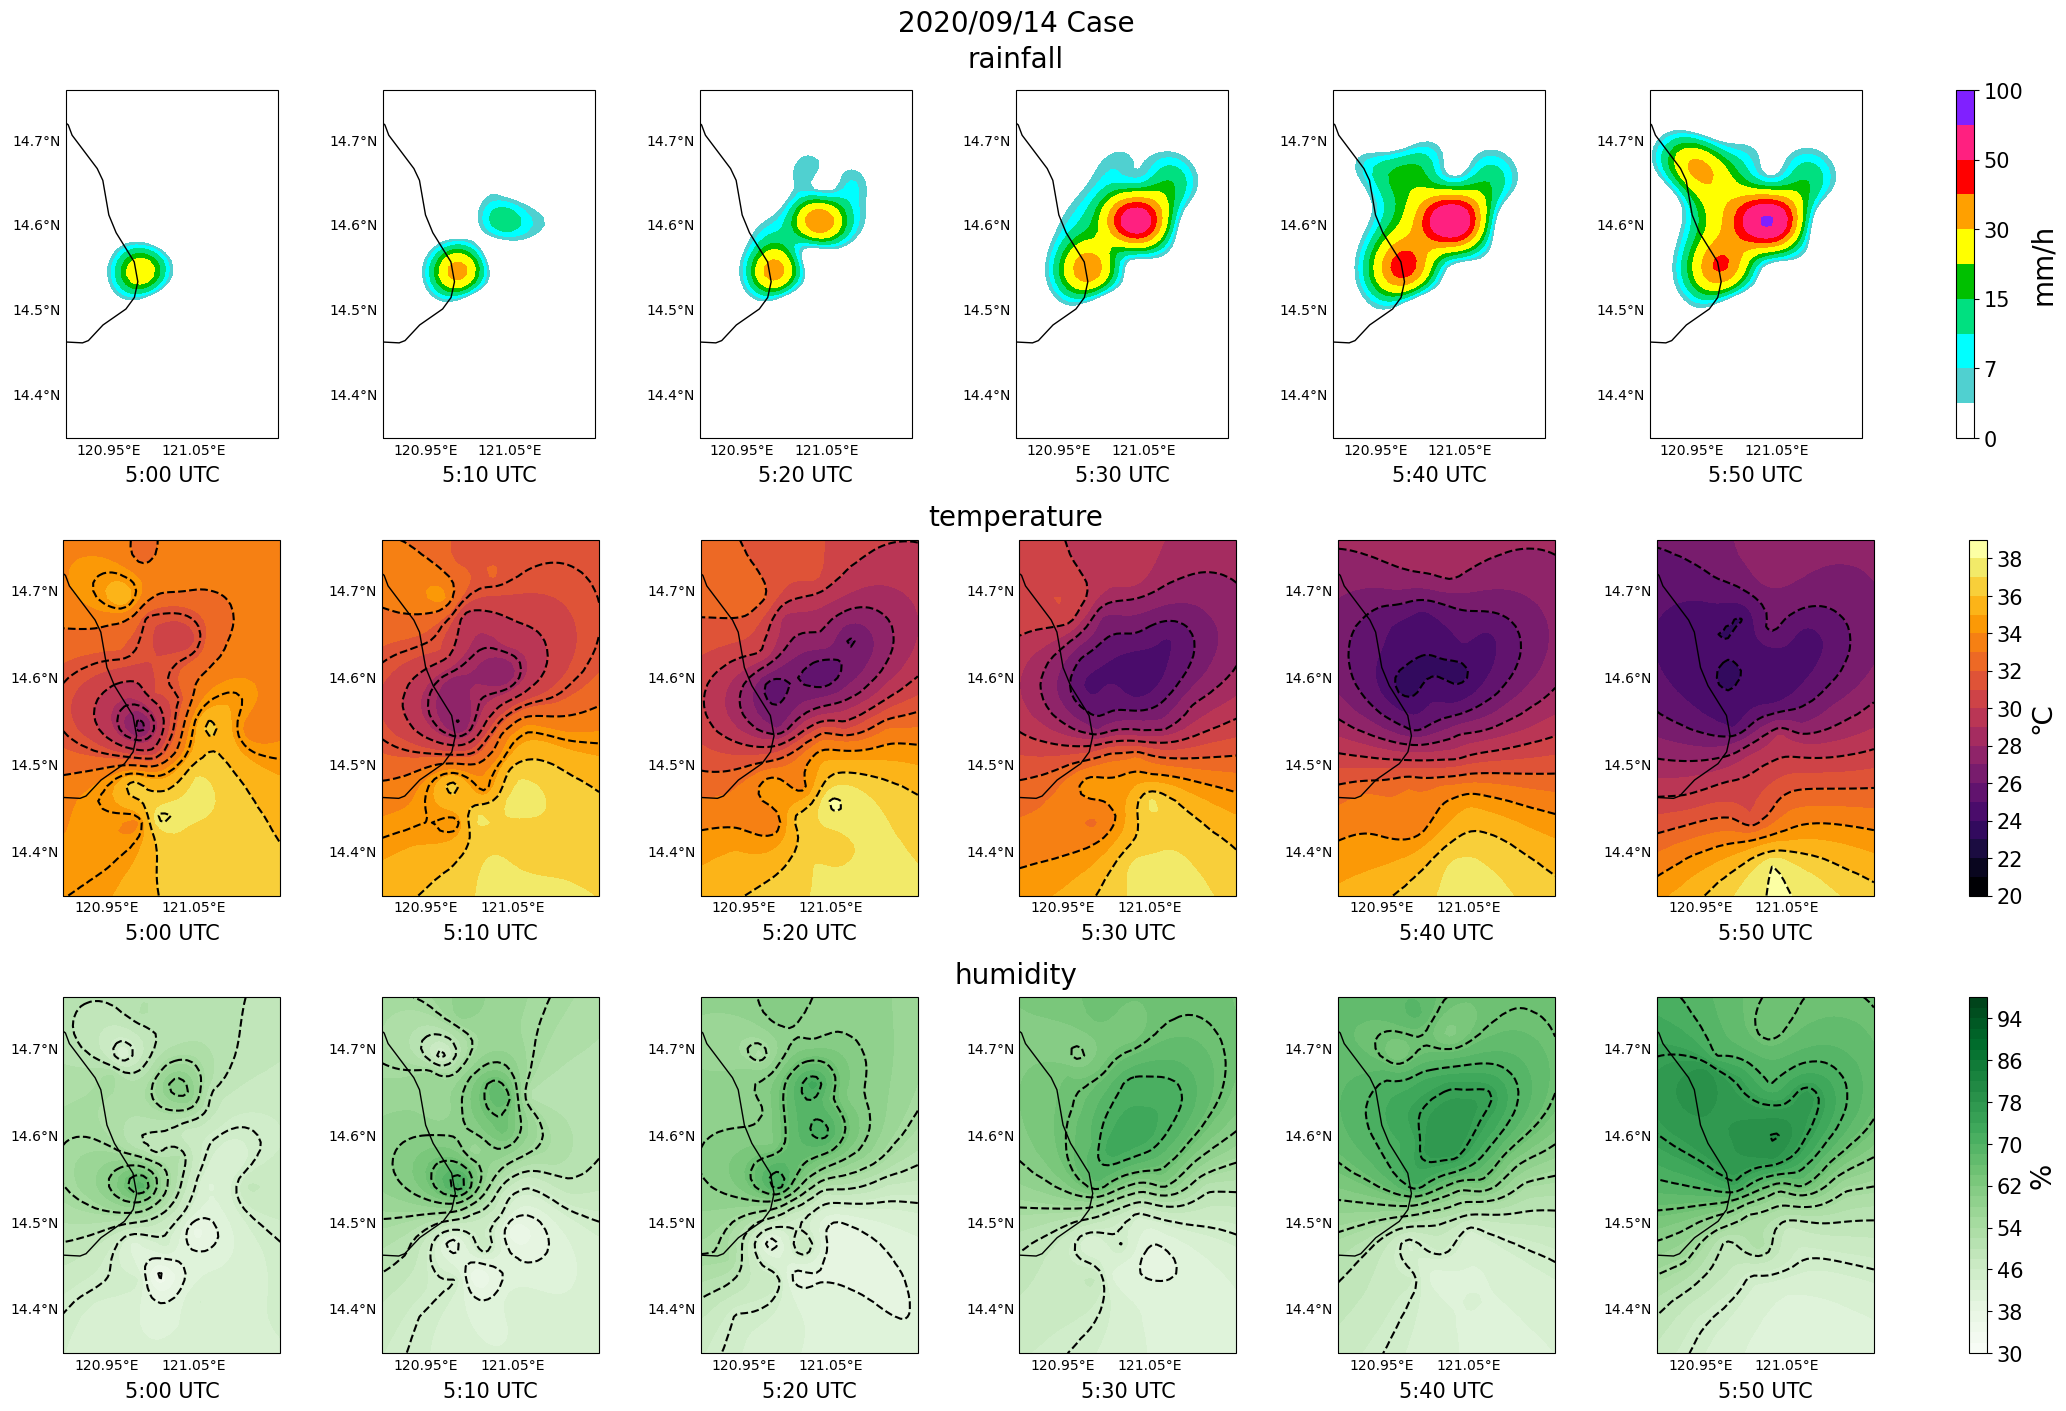

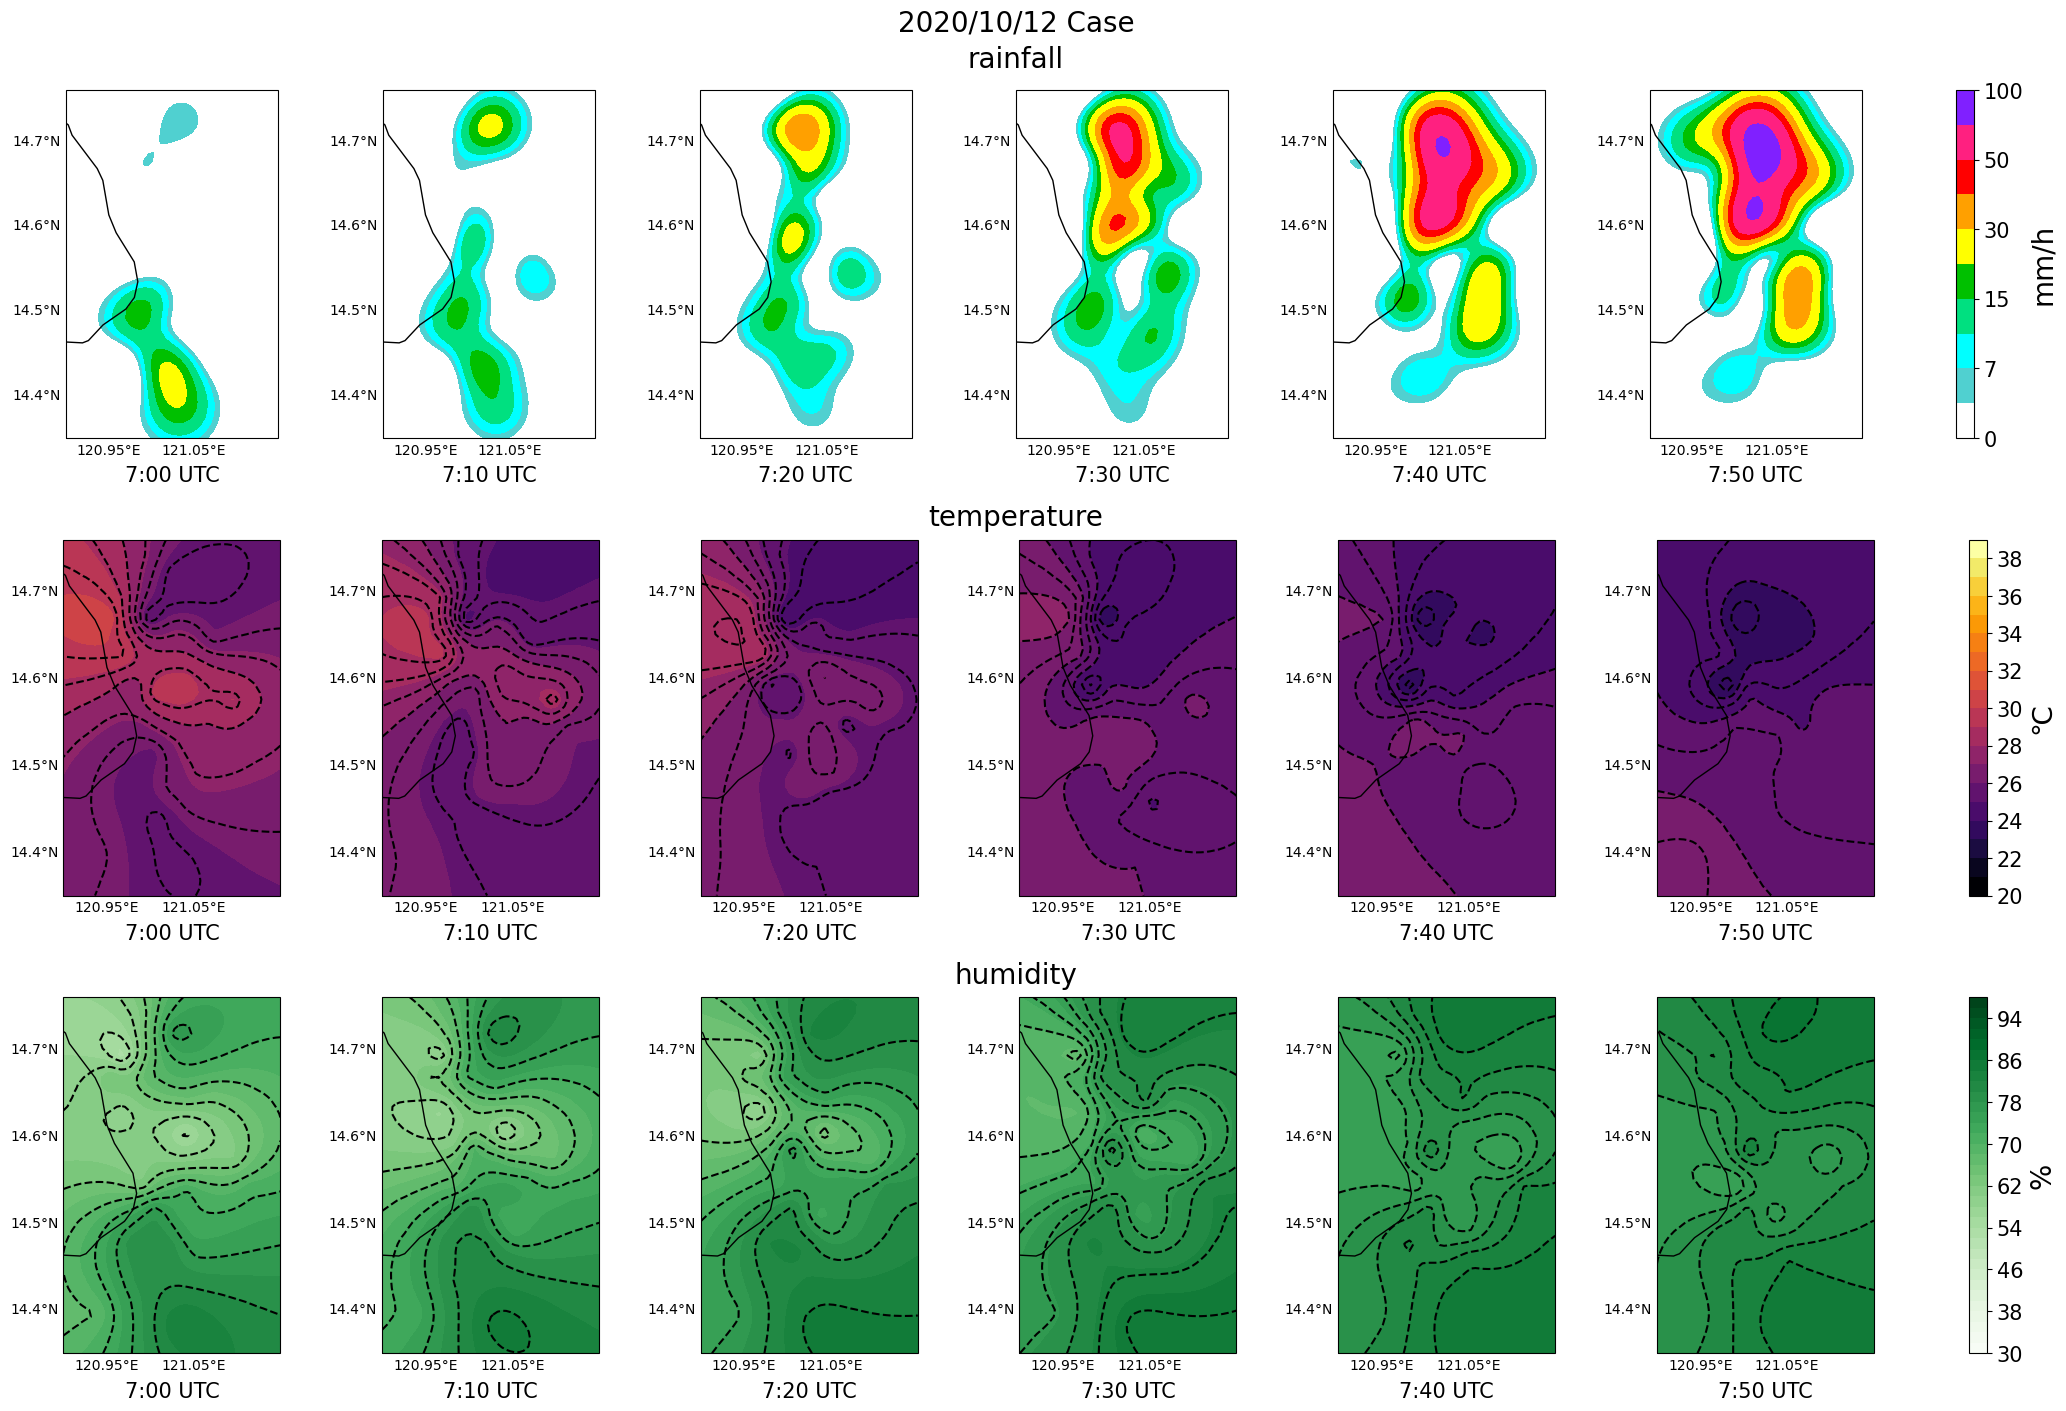

In [40]:
for target_type in ['input', 'label']:
    for test_case_name in TargetCases.good_case_names + TargetCases.bad_case_names:
        visualize_timeseries_change(test_case_name, target_type=target_type, save_fig_path=f'{test_case_name}_timeseriesChange_{target_type}.png')

TC_case_2020-10-12_8-0_start


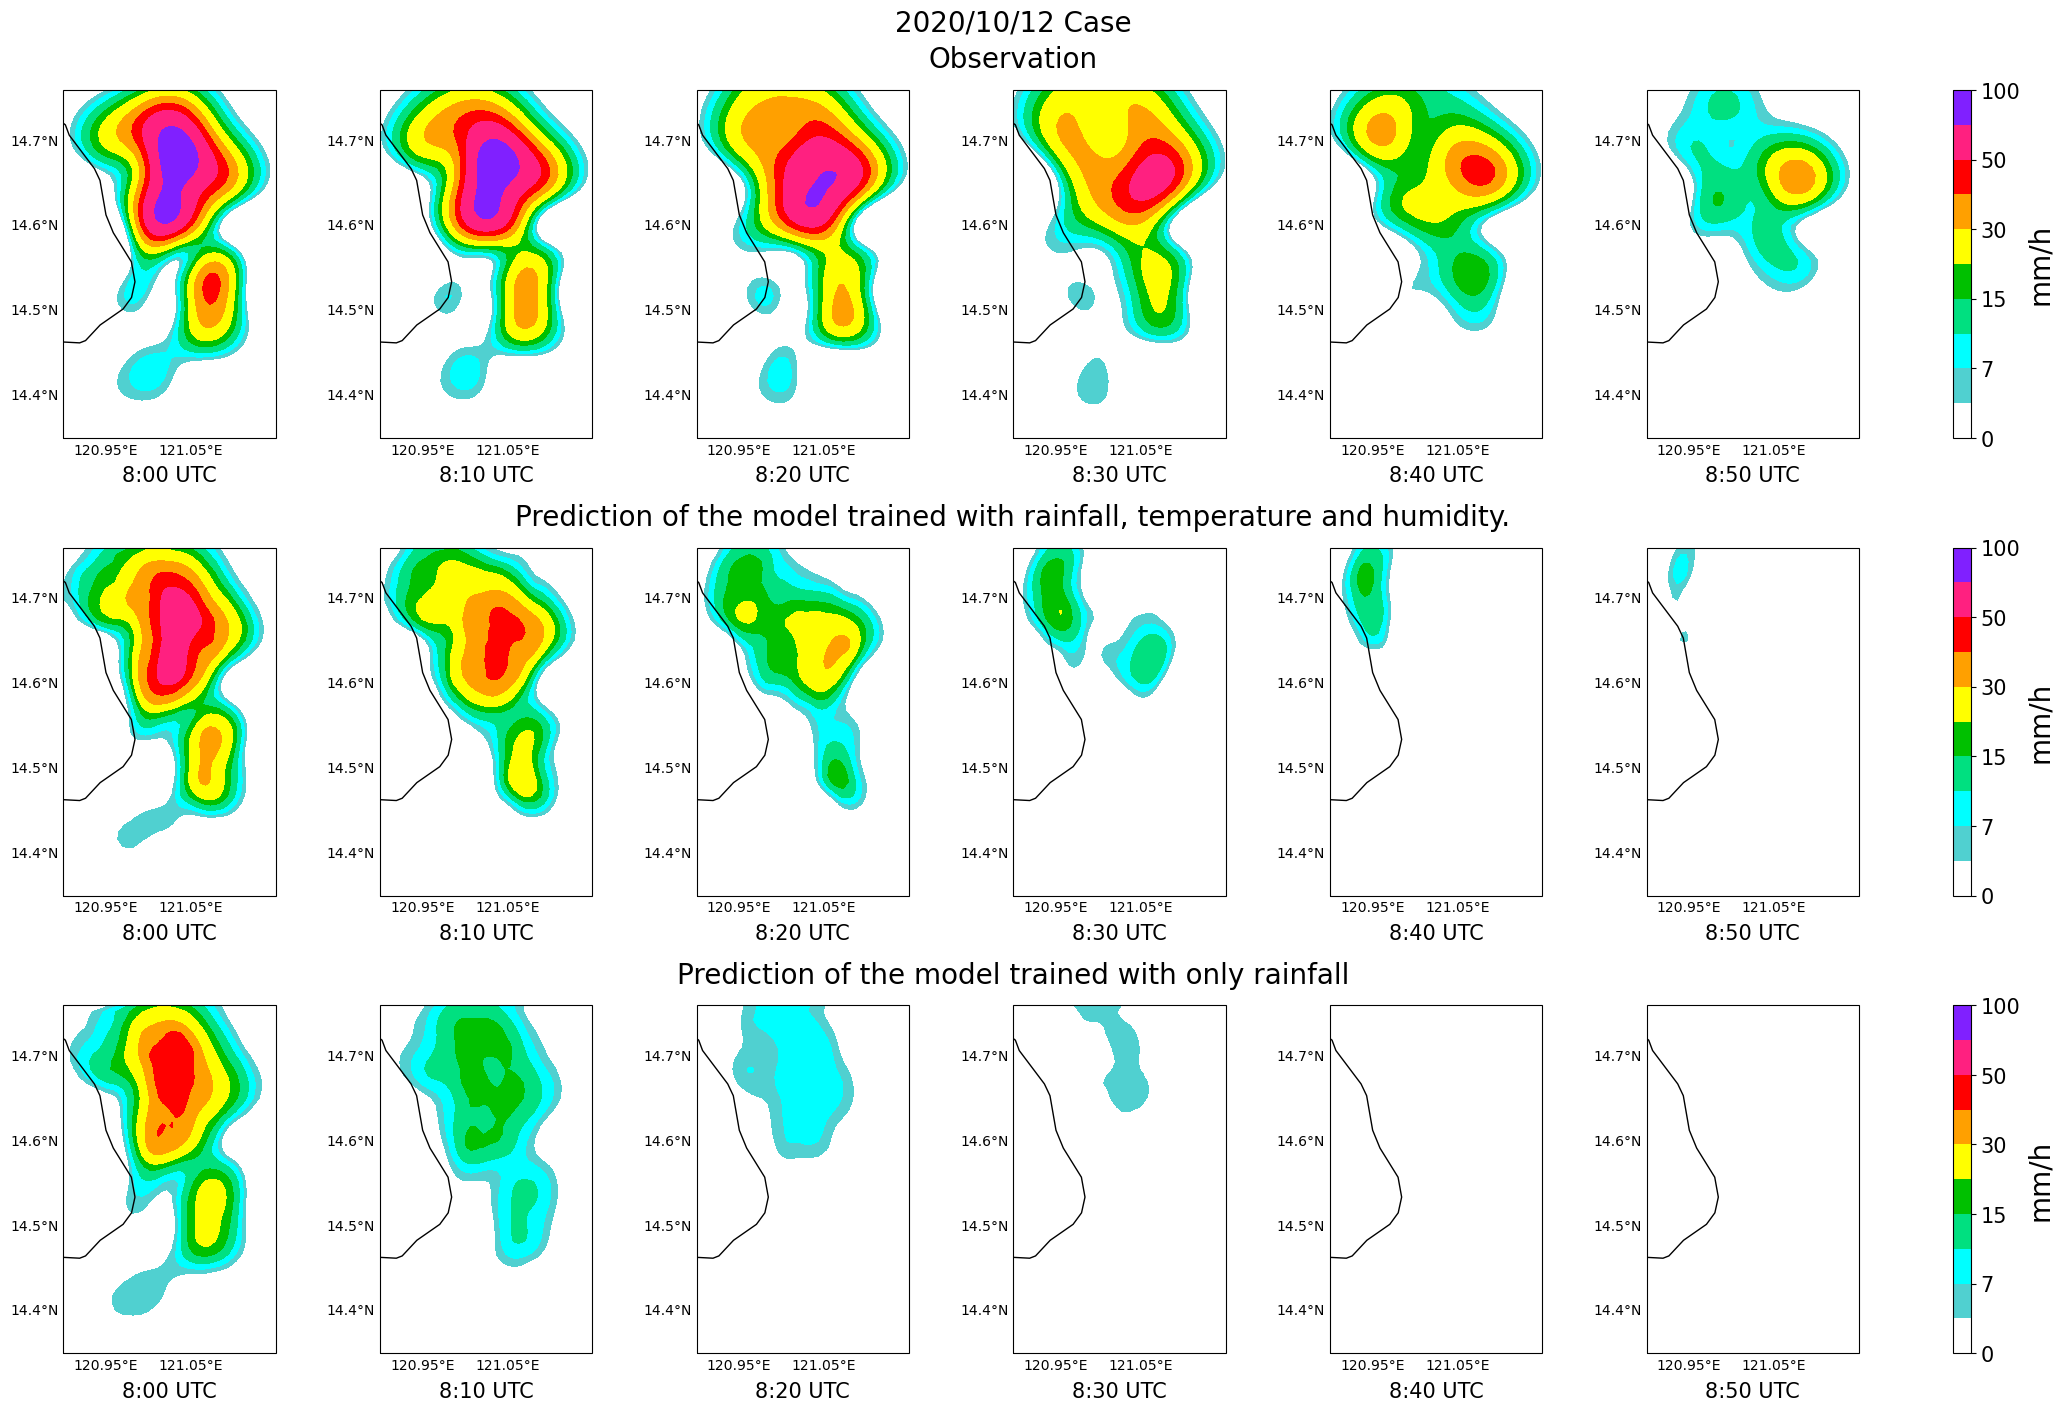

NOT_TC_case_2019-10-12_8-40_start


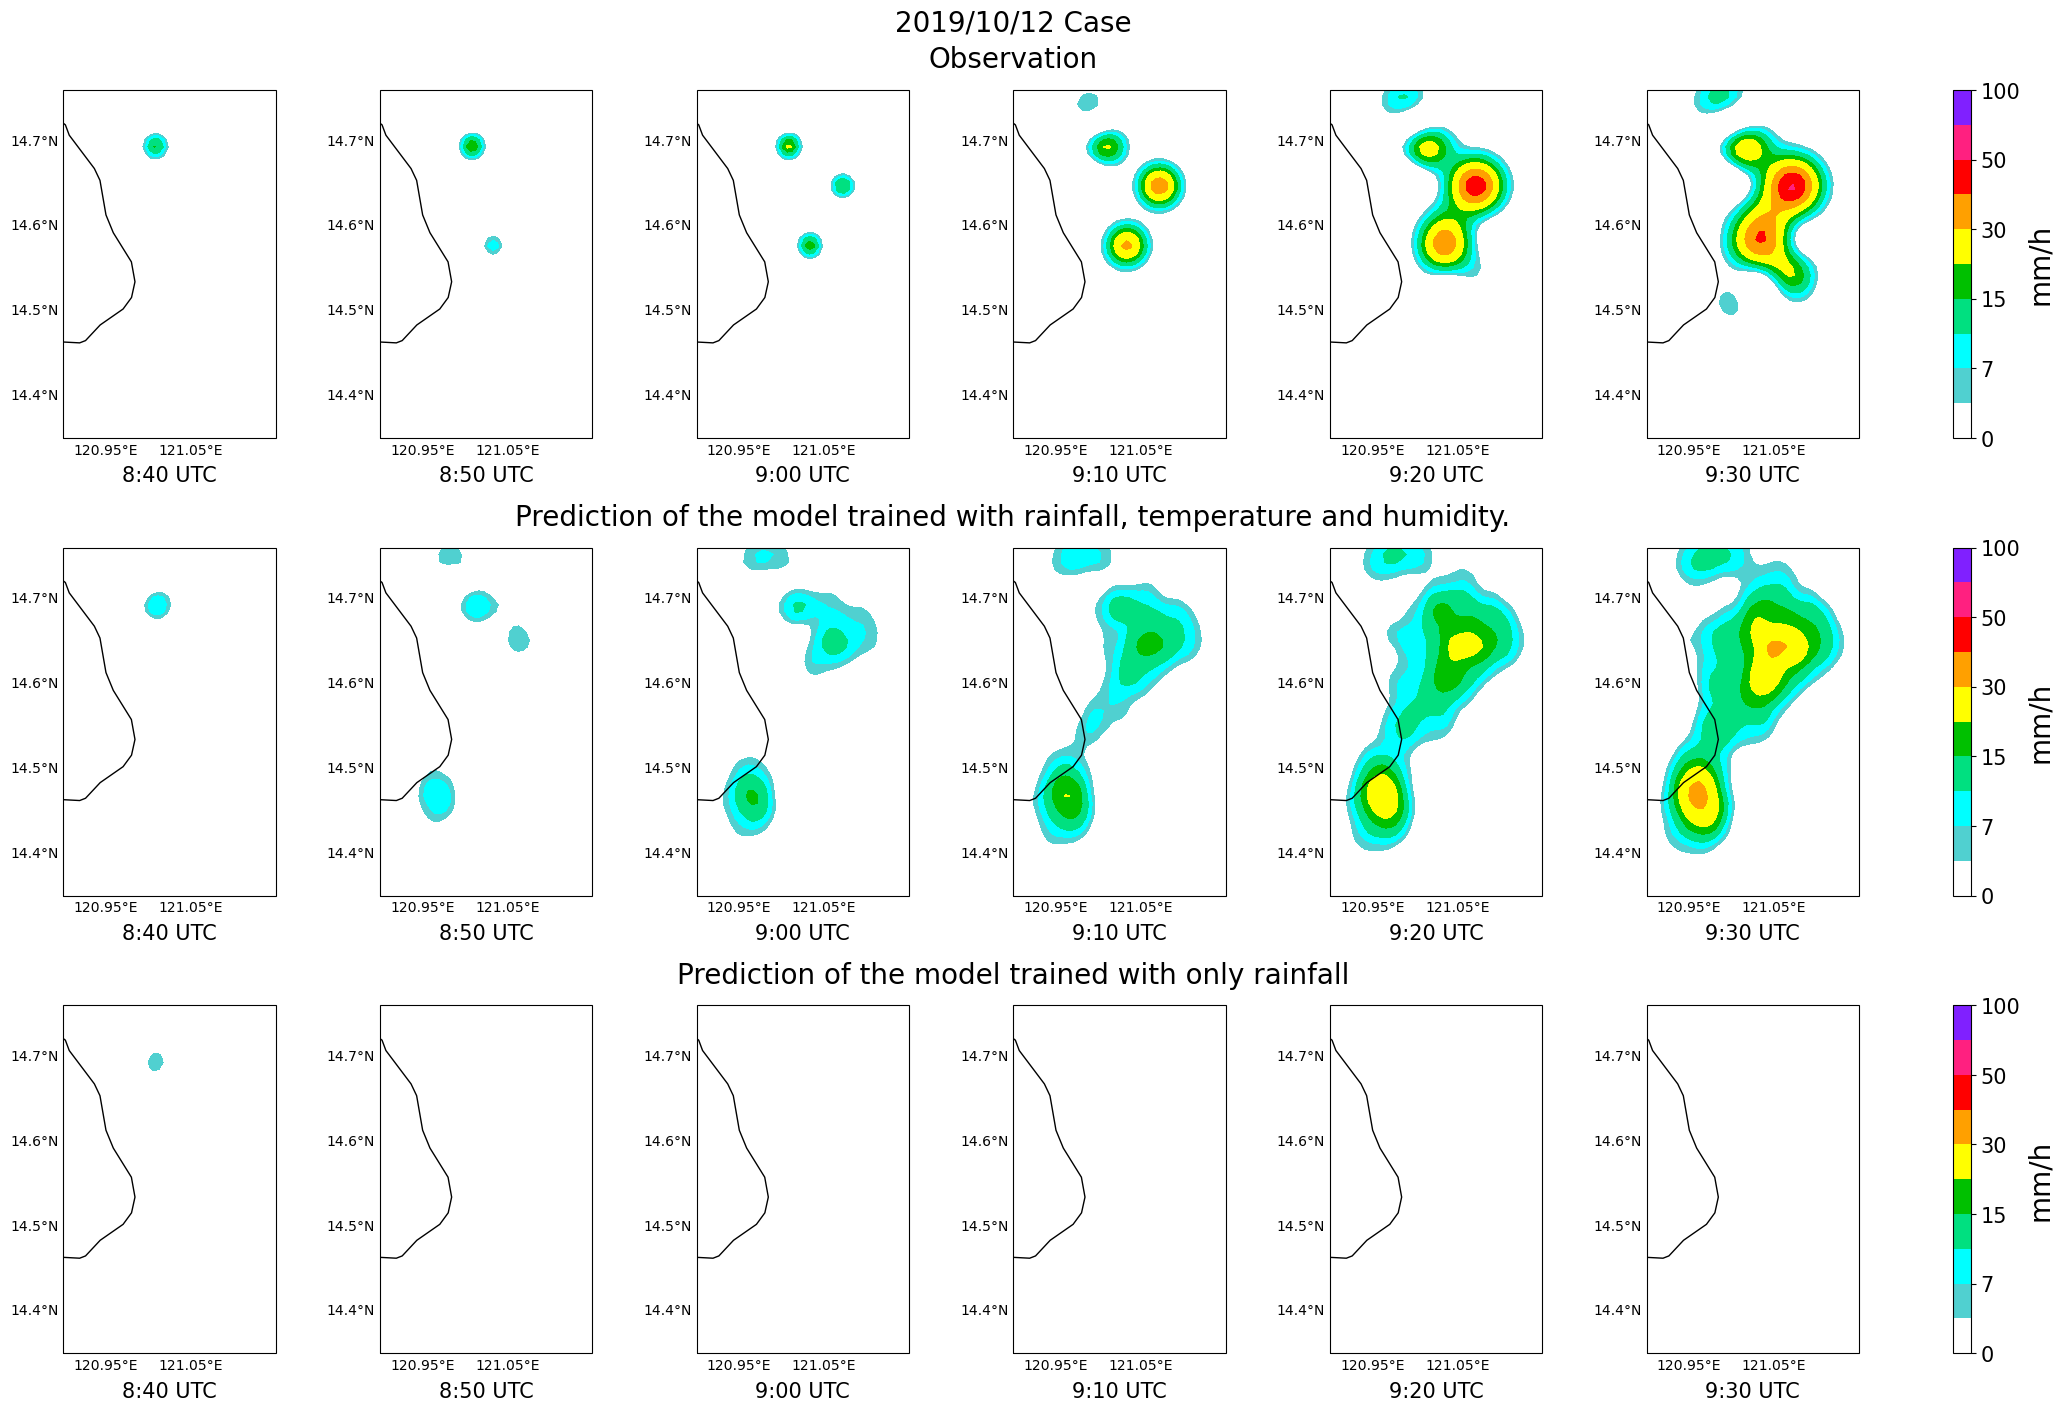

TC_case_2020-09-14_5-0_start


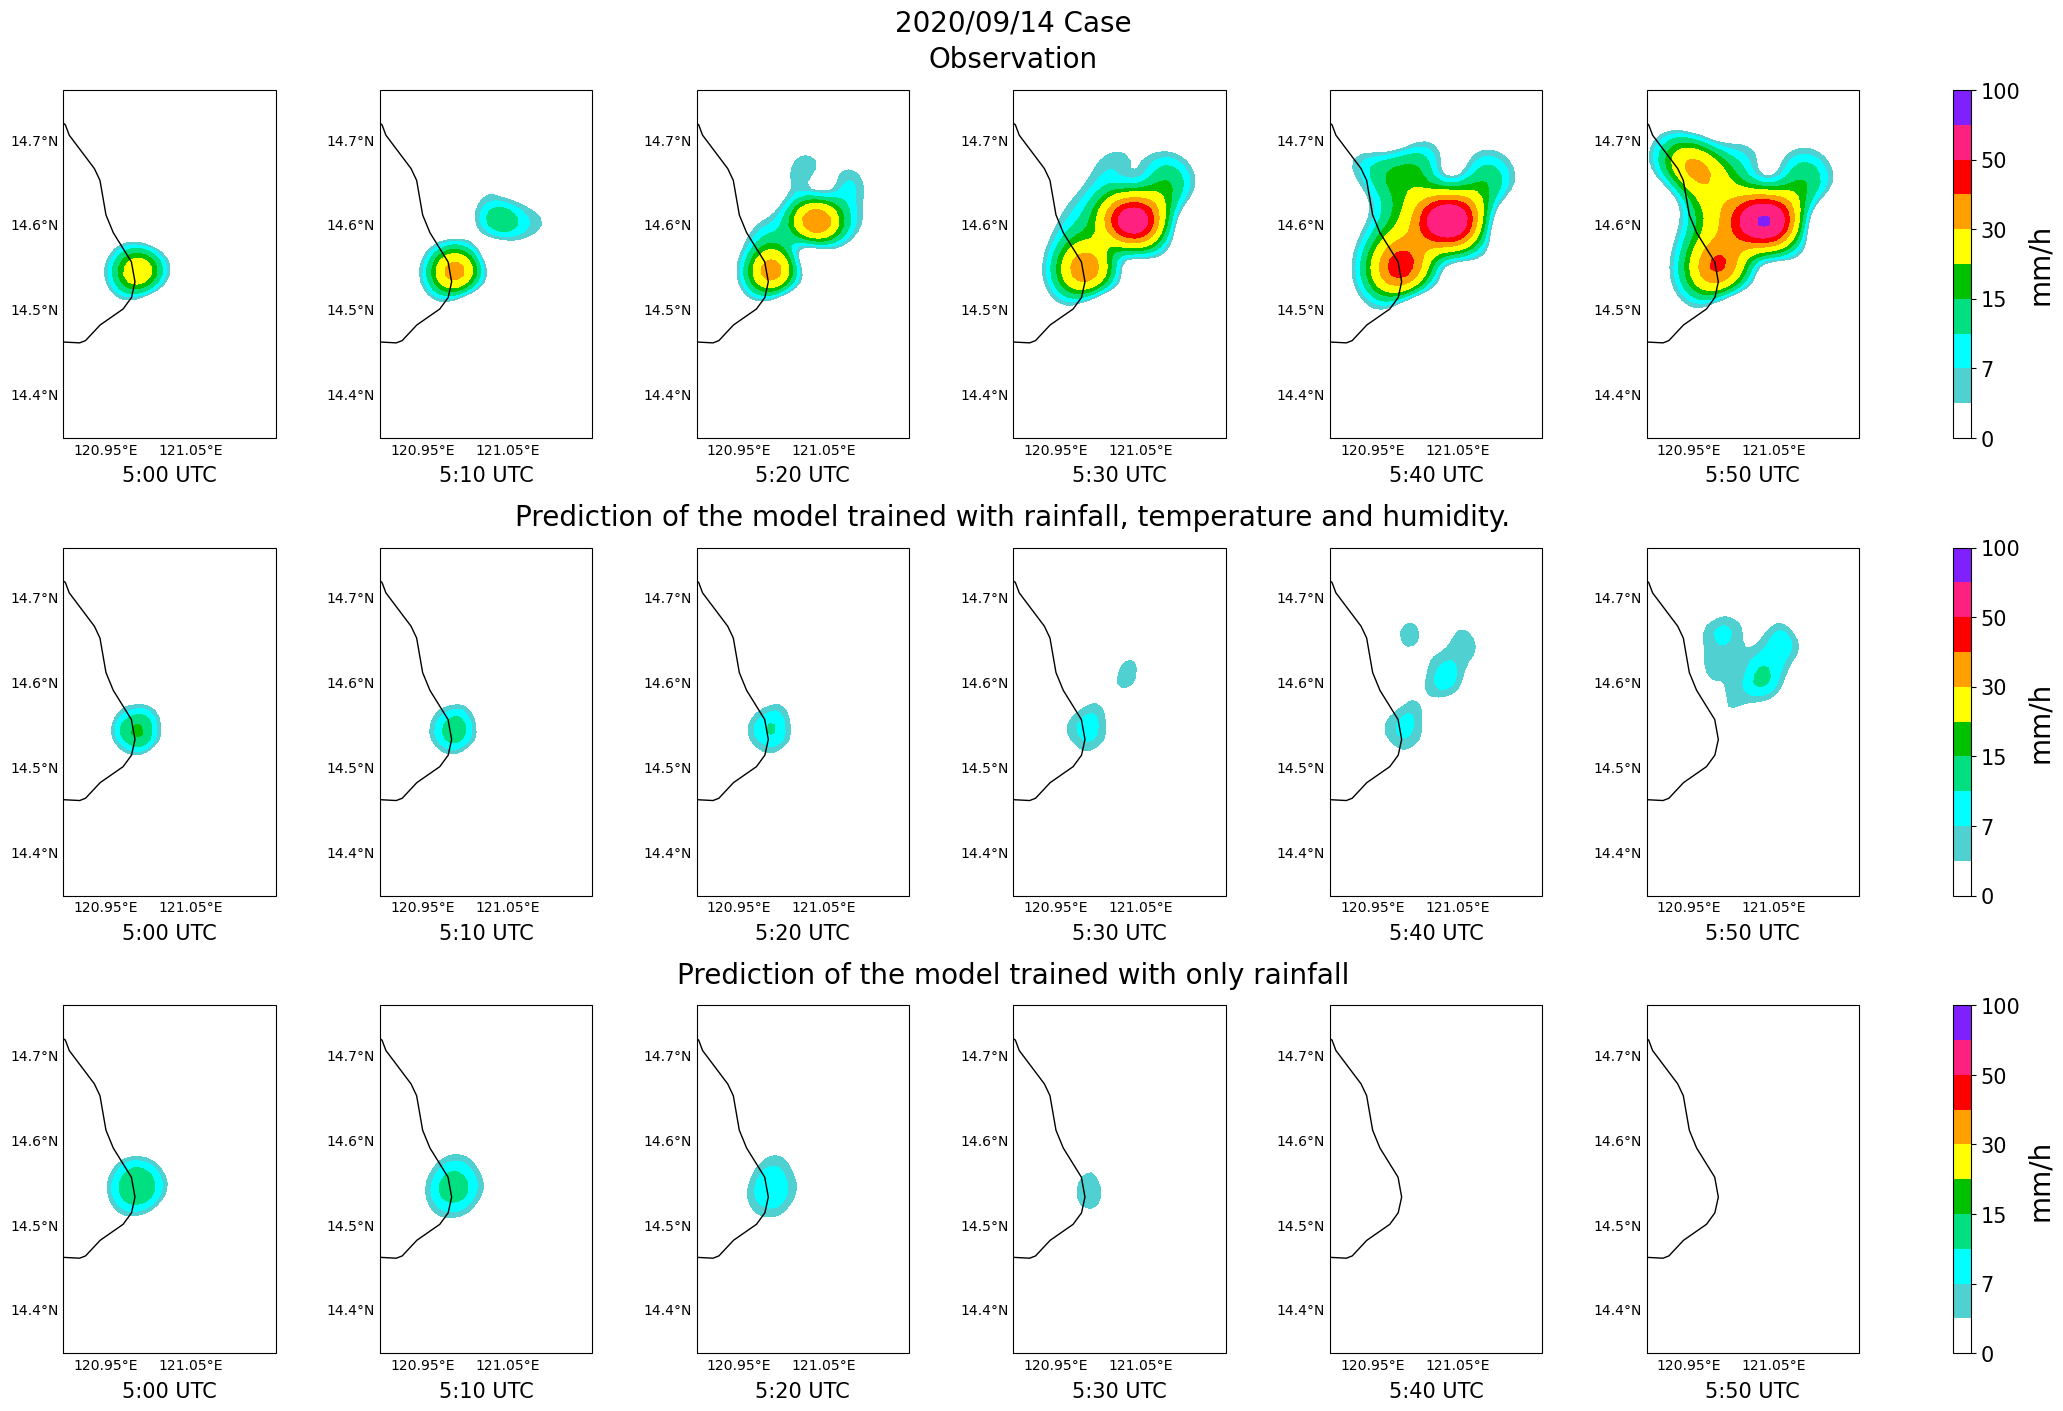

TC_case_2020-10-12_7-0_start


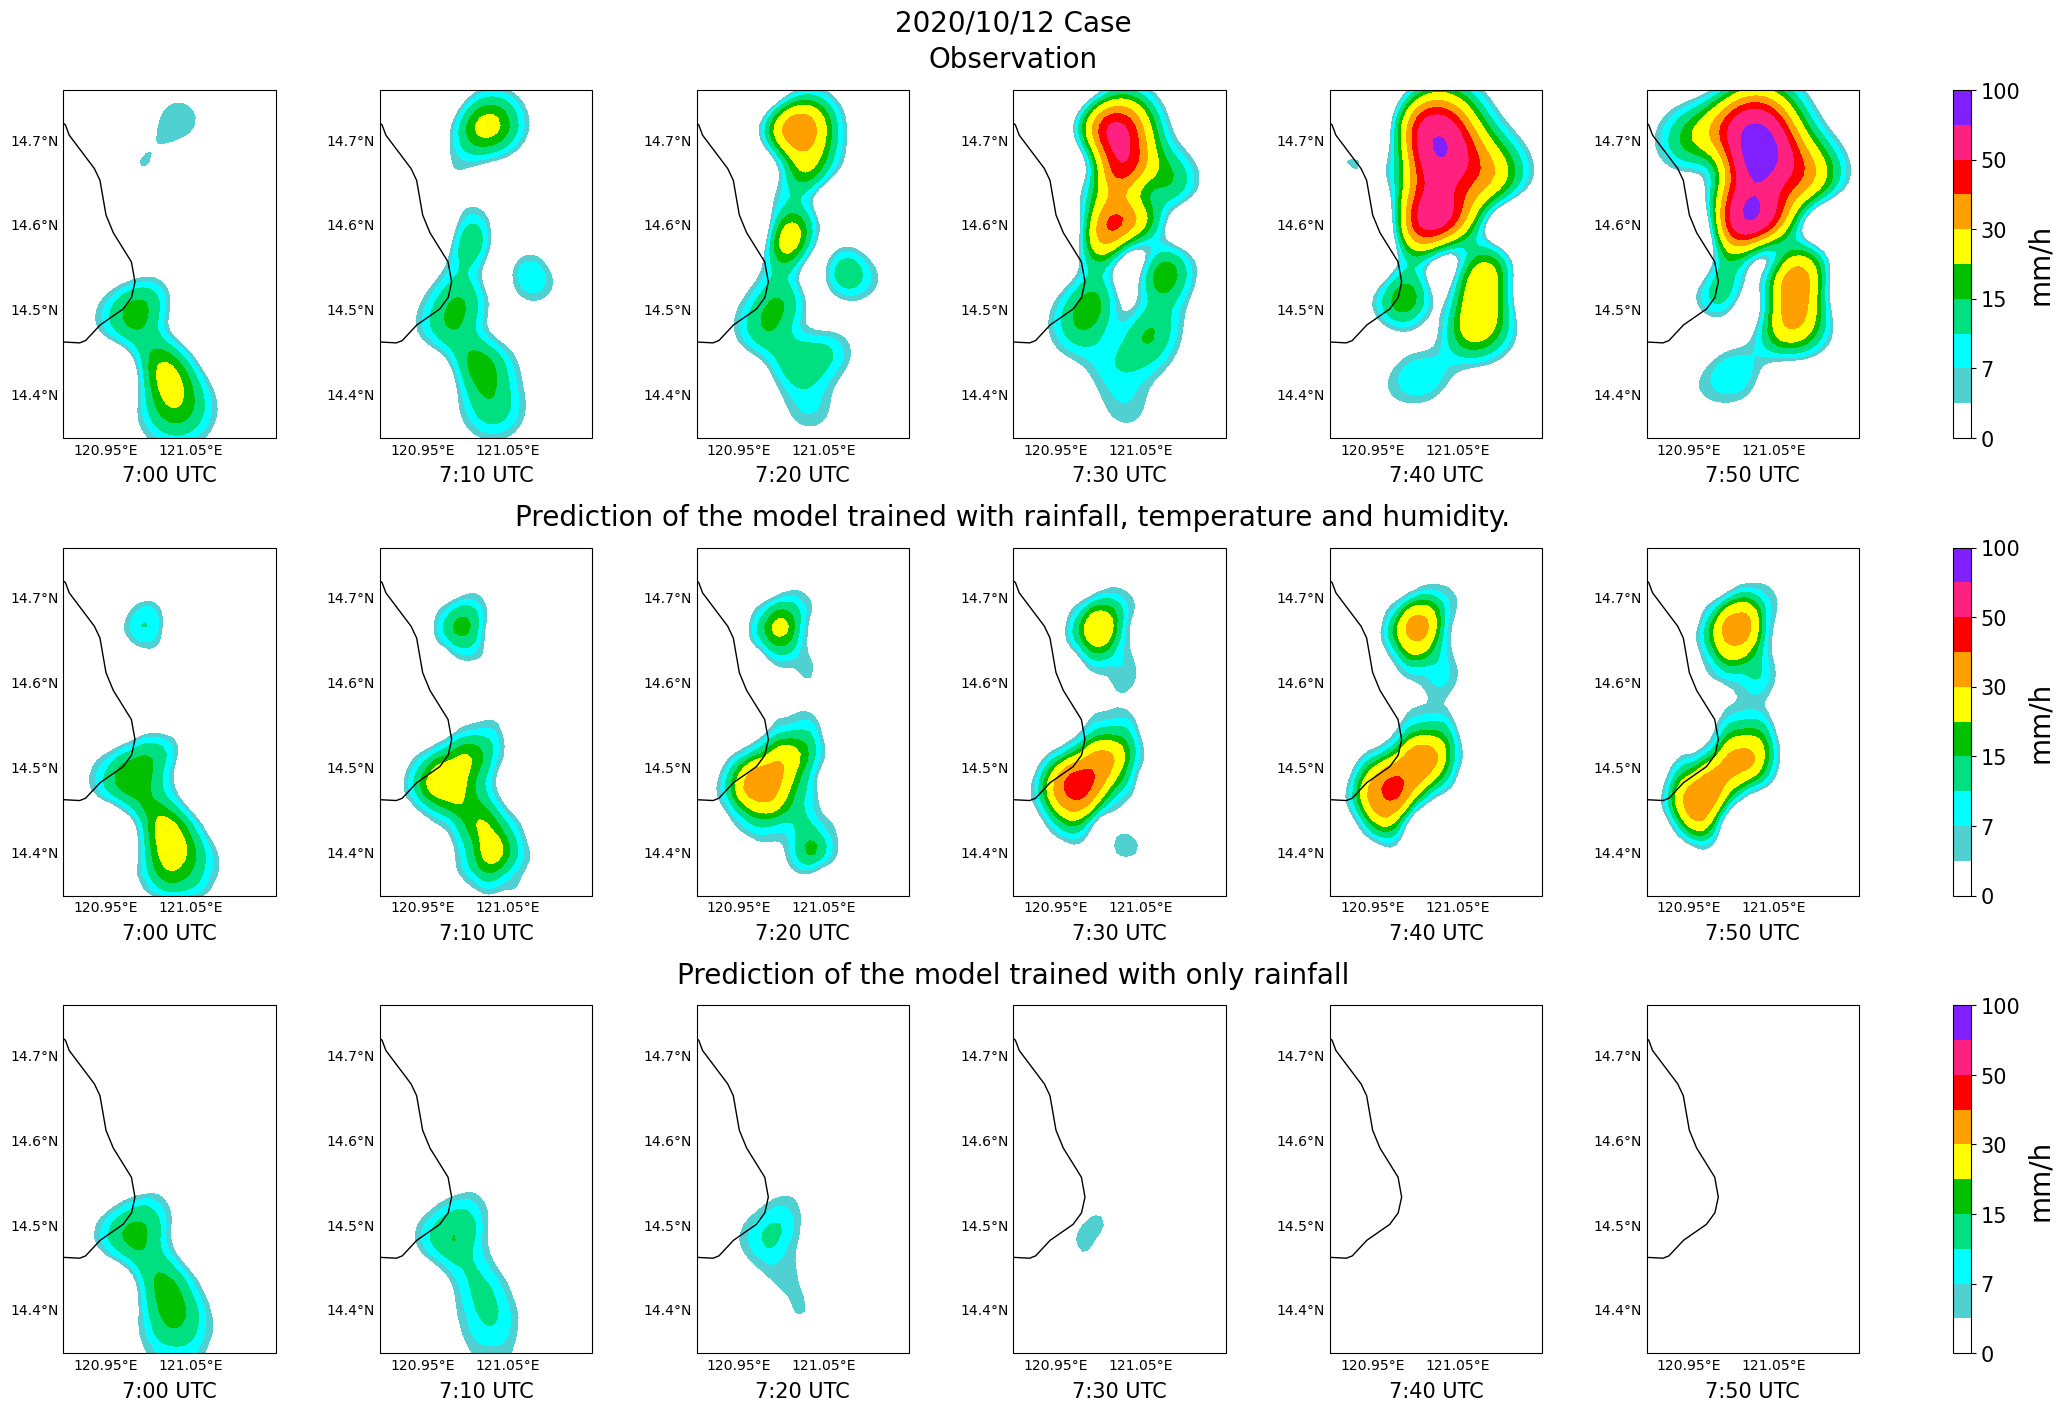

In [42]:
for test_case_name in TargetCases.good_case_names + TargetCases.bad_case_names:
    print(test_case_name)
    visualize_pred_vs_label(test_case_name, save_fig_path=f'{test_case_name}_prediction.png')

TC_case_2020-10-12_7-0_start


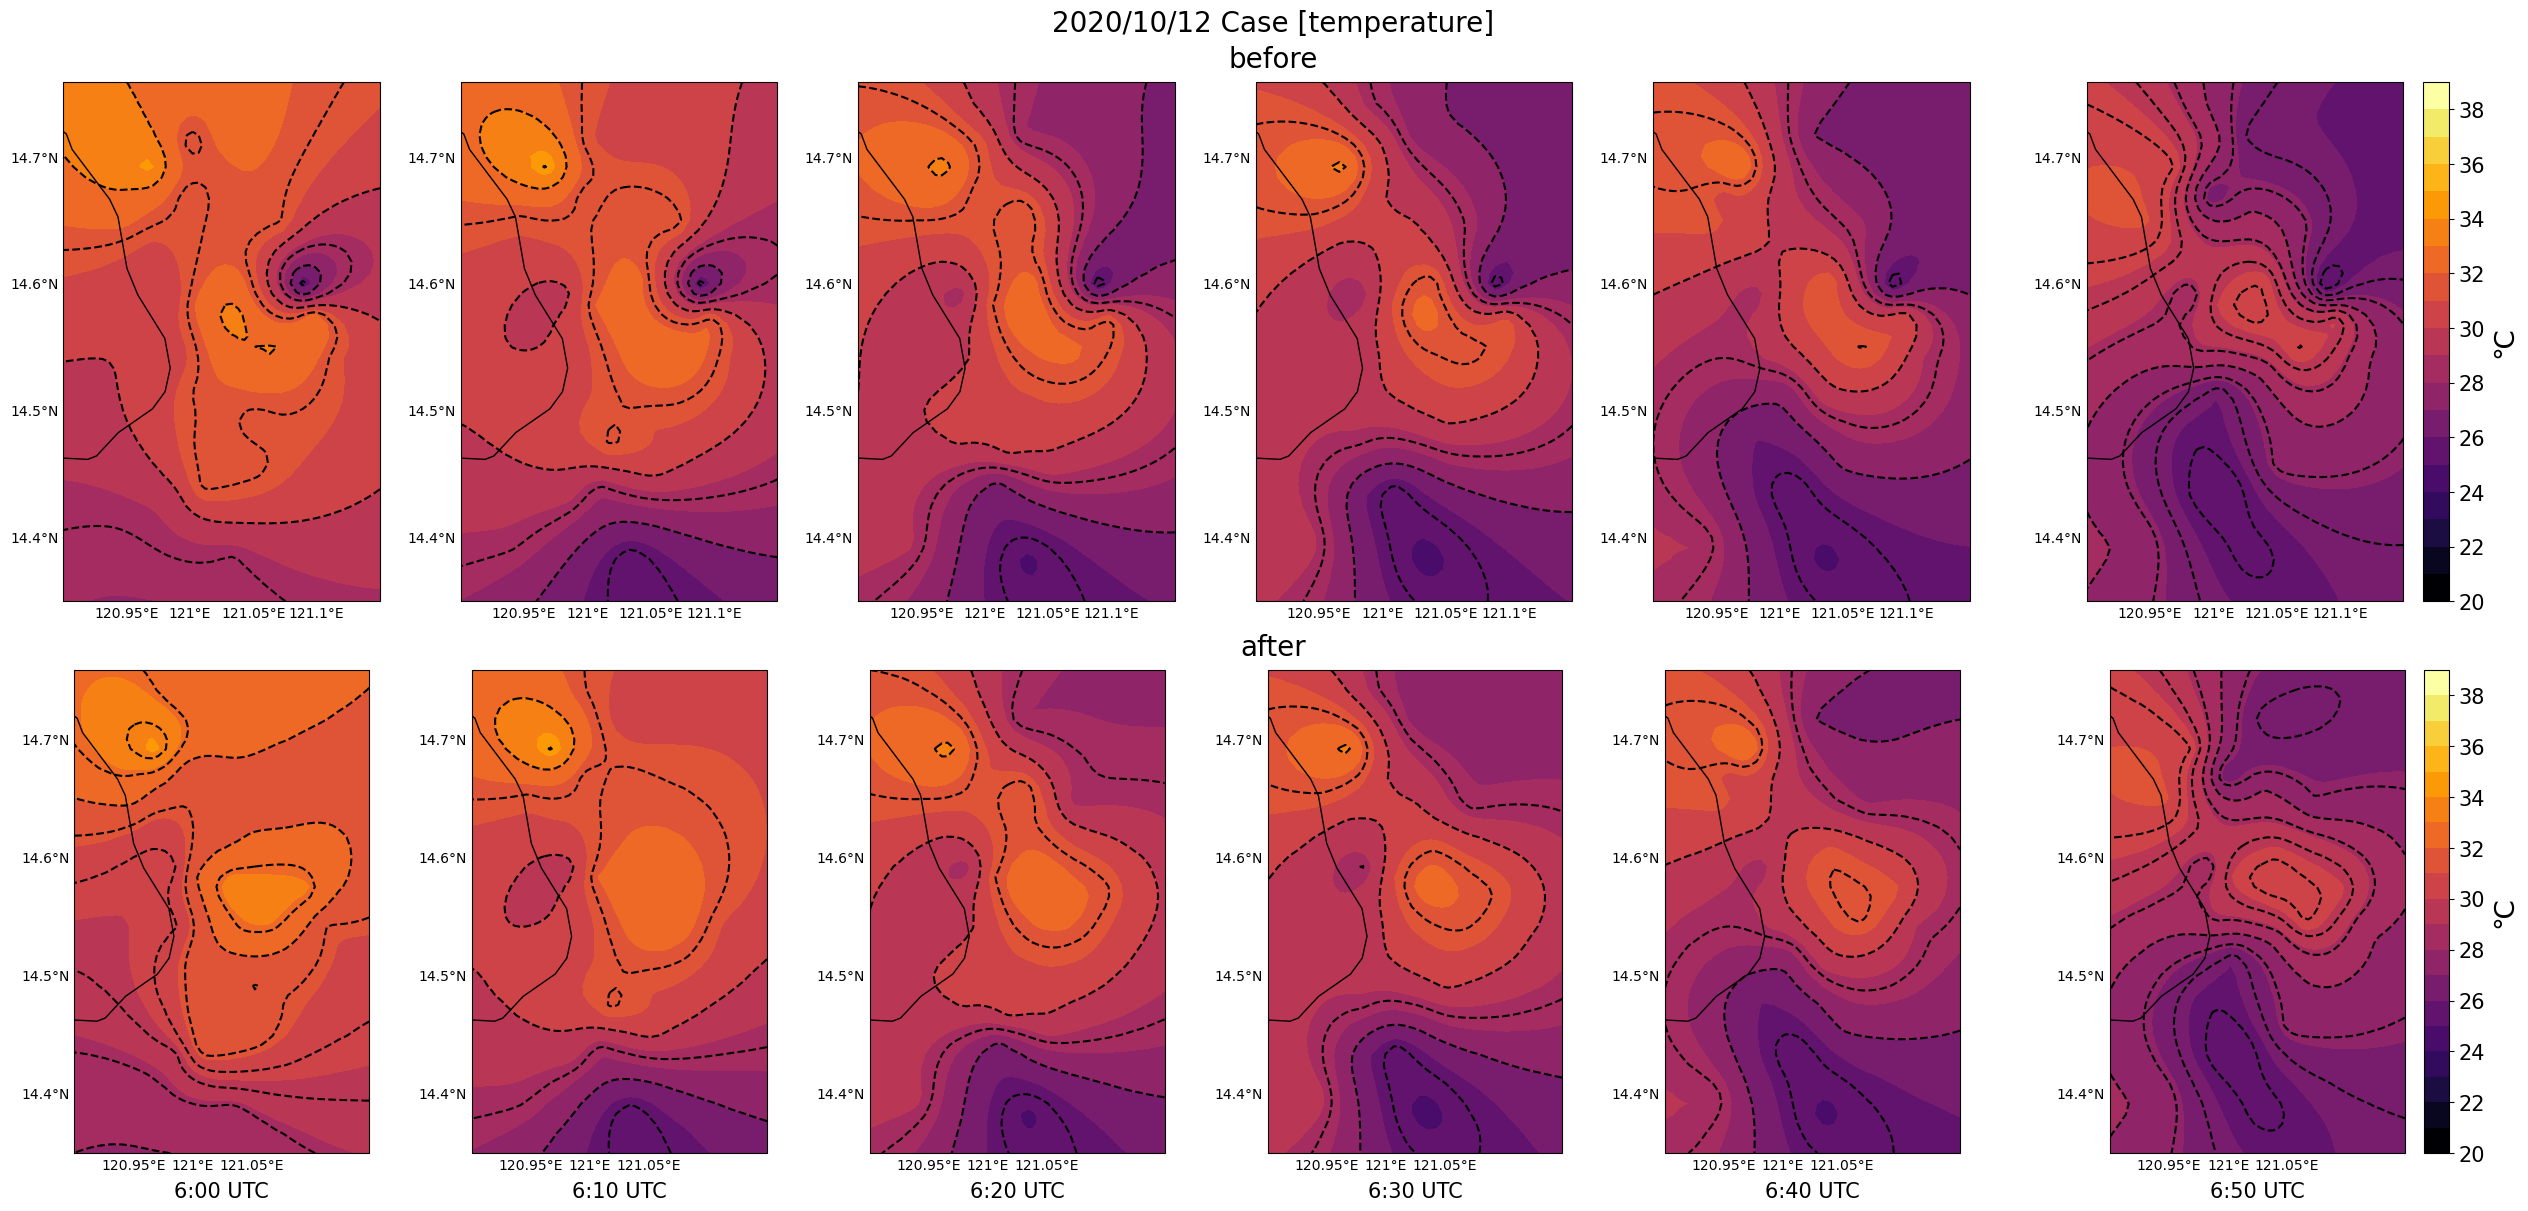

In [153]:
test_case_name = TargetCases.bad_case_names[1]
print(test_case_name)
visualize_interpolate_bf_af(test_case_name, MlflowConfig.eval_run_ids['rain_only'], target_param=WeatherParams.temperature)